# E2S - Summer 2024

## Key Question: “How to build a model that predicts the staff’s no-show rate for an event based on provided datasets”

### Table of Content:

1. What is No-Show Rate?
2. What is the Cost/Profit behind No-Show Rate?
3. Load and Clean Data
4. EDA with Visualization
5. Feature Engineering
6. Data Preprocessing Pipeline
7. Perdiction Model
8. Performance Analysis
9. Next Steps


## 1. What is No-Show Rate?

no-show rate = # of no-shows / # of total event expected staff


## 2. What is the Cost/Profit behind No-Show Rate?

Key Metrics (Conditions):

- maximize --> tips_per_person = total_tips / num_of_staff
- equalize --> num_of_staff_per_venue = num_of_staff / num_of_venues

Dependent Variables:

- num_of_staff

Cost of Hiring Staff:

- cost_of_hiring = num_of_staff \* fix_wage_rate


## 3 Cases:

### 1. Equal Case:

num_of_staff_per_venue == expected_num_of_staff_per_venue

- Maximization of tips_per_person
- Minimization of cost_of_hiring

### 2. Overstaffing Case:

num_of_staff_per_venue > expected_num_of_staff_per_venue

- Decrease in tips_per_person
- Increase in cost_of_hiring

### 3. Understaffing Case:

num_of_staff_per_venue < expected_num_of_staff_per_venue

- Bad performance and inefficiences
- Inefficiences result in Decrease in tips_per_person
- Low cost_of_hiring
- Low Sales ???


## 3. Load and Clean Data


In [1]:
# 1. Connect out notebook with out Google Drive and navigate to the directory in which we saved the data file(s)

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/E2S/dropout_rate_model

Mounted at /content/gdrive
/content/gdrive/MyDrive/E2S/dropout_rate_model


In [2]:
# 1. Load what we will need for data wrangling, visualization, and modeling
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Support functions for much later modeling
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scoring Functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [ ]:
# Loading Datasets:

# 1. Read data on employee_event:
employee_event = pd.read_csv('employee_event_202405221035.csv', dtype={
    'employee_id': 'int64',
    'event_id': 'int64',
    'attendance_status': 'category',
    'position_preference': 'float64',
    'employee_preference': 'float64',
    'stand_preference': 'float64',
}, parse_dates=['created_at', 'updated_at', 'deleted_at'])
employee_event.drop(columns=['id', 'source', 'notes'], inplace=True)

# 2. Read data on jobs:
jobs = pd.read_csv('jobs_202405221049.csv', dtype={
    'event_id': 'int64',
    'type': 'int64',
    'area_id': 'float64',
    'stand_id': 'float64',
    'stand_position_id': 'float64',
    'employee_id': 'float64',
    'check_out_description': 'category',
    'has_finished': 'bool',
}, parse_dates=['created_at', 'updated_at', 'deleted_at', 'check_in', 'check_out'])
jobs[['created_at', 'updated_at', 'deleted_at', 'check_in', 'check_out']] = jobs[['created_at', 'updated_at', 'deleted_at', 'check_in', 'check_out']].apply(pd.to_datetime, utc=True)

# 3. Read data on employee:
employees = pd.read_csv('employees_202405221058.csv', dtype={
    'user_id': 'int64',
    'check_employee_id': 'string',
    'uniform_status': 'category'
    }, parse_dates=['date_of_birth', 'created_at', 'updated_at', 'deleted_at', 'banned_at', 'last_activity'])
employees.drop(columns=['date_of_birth', 'legal_first_name', 'legal_middle_name', 'legal_last_name', 'taxpayer_identification_number', 'truncated_taxpayer_identification_number', 'check_payment_method', 'workbright_employee_id', 'w2_electronic_consent', 'checkr_candidate_id' ], inplace=True)
#employees[['date_of_birth', 'created_at', 'updated_at', 'deleted_at', 'banned_at', 'last_activity']].apply(pd.to_datetime, utc=True)
employees['banned_at'] = pd.to_datetime(employees['banned_at'], utc=True)
employees['last_activity'] = pd.to_datetime(employees['last_activity'], utc=True)

# 4. Read data on events:
events = pd.read_csv('events_202405231223.csv', dtype={
    'venue_id': 'int64',
    'name': 'string',
    'notifications_frequency': 'int64',
    'employee_capacity': 'float64',
    'automate_roster': 'bool',
    'buffer': 'int64',
}, parse_dates=['held_on', 'created_at', 'updated_at', 'allow_registrations_at', 'report_time', 'deleted_at', 'finished_at'])
events.drop(columns=['group_me_url', 'event_logistics_url', 'event_training_url'], inplace=True)
events['finished_at'] = pd.to_datetime(events['finished_at'], utc=True)
events['deleted_at'] = pd.to_datetime(events['deleted_at'], utc=True)
events['report_time'] = pd.to_datetime(events['report_time'], utc=True)


# 5. Read data on warnings:
warnings = pd.read_csv('warnings_202405311707.csv', dtype={
    "id": 'int64',
    "recipient_id": 'int64',
    "warning_type": "category",
    "warning": "str",
    "event_id": "int64"
})
warnings.drop(columns=["source_id", "objective_status", "accepted","code","updated_at","deleted_at"], inplace=True)
warnings['created_at'] = pd.to_datetime(warnings['created_at'], utc=True)

In [4]:
employee_event.info()
jobs.info()
employees.info()
events.info()
warnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45854 entries, 0 to 45853
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   employee_id          45854 non-null  int64         
 1   event_id             45854 non-null  int64         
 2   created_at           45854 non-null  datetime64[ns]
 3   updated_at           31984 non-null  datetime64[ns]
 4   deleted_at           0 non-null      datetime64[ns]
 5   attendance_status    45854 non-null  category      
 6   position_preference  7184 non-null   float64       
 7   employee_preference  2755 non-null   float64       
 8   stand_preference     4145 non-null   float64       
dtypes: category(1), datetime64[ns](3), float64(3), int64(2)
memory usage: 2.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43016 entries, 0 to 43015
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  -----

## 3.3 Examine Data


In [5]:
employee_event.describe()
# Insights:
# 1. The dataset has 8 columns and 45,854 rows

,employee_id,event_id,created_at,updated_at,deleted_at,position_preference,employee_preference,stand_preference
count,45854.000000,45854.000000,45854,31984,0,7184.000000,2755.000000,4145.000000
mean,3751.415536,893.595782,2023-08-09 23:06:31.050726400,2023-07-13 08:54:07.715607552,NaT,13.020045,2765.536842,6983.969843
min,1.000000,4.000000,2022-09-05 16:41:06,2022-09-05 16:41:06,NaT,3.000000,6.000000,3449.000000
25%,1024.000000,477.000000,2023-03-23 00:09:55.500000,2023-01-18 22:56:46.750000128,NaT,12.000000,328.000000,6415.000000
50%,2991.000000,945.000000,2023-09-02 14:18:19,2023-09-08 19:01:20.500000,NaT,13.000000,1339.000000,7261.000000
75%,6380.000000,1274.000000,2024-01-02 14:20:34,2023-11-24 17:27:02.750000128,NaT,13.000000,5244.000000,7648.000000
max,10056.000000,1864.000000,2024-05-17 03:27:17,2024-05-17 03:34:40,NaT,49.000000,9441.000000,7986.000000
std,3038.957751,502.599166,NaN,NaN,NaN,6.059351,2831.517603,906.280734


In [6]:
jobs.describe()
# Insights:
# 1. The dataset has 6 columns and 43,016 rows.

,id,event_id,type,area_id,stand_id,stand_position_id,employee_id
count,43016.000000,43016.000000,43016.000000,542.000000,4563.000000,36061.000000,42768.000000
mean,21779.163125,917.918658,2.739702,853.116236,4387.075827,5627.634453,3981.406776
std,12550.539410,452.505538,0.689781,469.454924,2771.879970,3078.060490,3102.734413
min,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000
25%,10796.750000,593.750000,3.000000,623.000000,1741.500000,2888.000000,1001.750000
50%,21878.500000,967.000000,3.000000,980.000000,4861.000000,5933.000000,3289.000000
75%,32637.250000,1186.000000,3.000000,1184.750000,6778.500000,7954.000000,6775.000000
max,43405.000000,1864.000000,3.000000,2060.000000,10601.000000,12035.000000,10056.000000


In [7]:
employees.describe()
# Insights:
# 1. The dataset has 4 columns and 10,011 rows.

,id,user_id,created_at,updated_at,deleted_at
count,10011.000000,10011.00000,10010,9851,0
mean,5092.732594,5609.93617,2023-06-11 07:10:37.663936256,2023-08-22 07:47:01.373160192,NaT
min,1.000000,1.00000,2022-08-14 12:12:37,2022-08-15 12:21:31,NaT
25%,2591.500000,2779.50000,2023-02-10 20:03:03.500000,2023-05-08 13:12:04,NaT
50%,5112.000000,5653.00000,2023-08-01 05:33:23.500000,2023-09-02 16:04:11,NaT
75%,7617.500000,8423.50000,2023-09-13 17:47:30.750000128,2023-12-19 12:31:20,NaT
max,10124.000000,11240.00000,2024-05-17 02:41:57,2024-05-17 02:59:12,NaT
std,2919.966700,3266.07115,NaN,NaN,NaN


In [8]:
events.describe()
# Insights:
# 1. The dataset has 8 columns and 1794 rows

,id,venue_id,held_on,created_at,updated_at,allow_registrations_at,employee_capacity,notifications_frequency,buffer
count,1794.000000,1794.000000,1794,1794,1709,1744,925.000000,1794.0,1794.000000
mean,950.830546,32.409142,2023-09-01 02:36:26.886844928,2023-07-16 11:19:11.470457344,2023-08-17 01:29:55.887068416,2023-07-22 21:22:30.482224640,33.365405,6.0,0.954849
min,1.000000,1.000000,2021-12-19 00:00:00,2022-08-27 17:13:56,2022-09-05 12:07:47,2022-06-27 04:00:00,0.000000,6.0,0.000000
25%,492.250000,11.000000,2023-03-18 00:00:00,2023-01-15 00:29:43.500000,2023-01-15 19:51:08,2023-01-15 05:52:00,7.000000,6.0,0.000000
50%,967.500000,34.000000,2023-09-09 23:45:00,2023-06-28 16:55:58.500000,2023-10-10 02:08:24,2023-06-30 04:00:00,14.000000,6.0,0.000000
75%,1415.750000,44.000000,2024-02-25 00:52:30,2024-02-07 04:18:19,2024-02-14 02:51:14,2024-02-09 05:00:00,40.000000,6.0,0.000000
max,1864.000000,100.000000,2024-11-16 18:00:00,2024-05-15 16:09:28,2024-05-17 02:55:34,2024-10-14 04:00:00,1000.000000,6.0,150.000000
std,538.613701,26.071245,NaN,NaN,NaN,NaN,54.740222,0.0,4.980797


In [9]:
warnings.describe()
# Insights:


,id,recipient_id,event_id
count,1178.000000,1178.000000,1178.000000
mean,589.500000,6615.010187,1596.335314
std,340.203616,3959.163975,128.209646
min,1.000000,5.000000,1105.000000
25%,295.250000,2868.000000,1532.000000
50%,589.500000,8007.000000,1614.500000
75%,883.750000,10399.000000,1700.000000
max,1178.000000,11160.000000,1856.000000


In [10]:
# Get unique counts for each df:
print("employee_event:\n", employee_event.nunique(), "\n")
print("jobs:\n", jobs.nunique(), "\n")
print("employees:\n", employees.nunique(), "\n")
print("events:\n", events.nunique(), "\n")
print("warnings:\n", warnings.nunique(), "\n")

# Insigts:


employee_event:
 employee_id             5197
event_id                1679
created_at             44354
updated_at             31101
deleted_at                 0
attendance_status          5
position_preference       16
employee_preference      518
stand_preference         874
dtype: int64 

jobs:
 id                       43016
event_id                  1562
type                         4
area_id                    341
stand_id                  4037
stand_position_id         9280
employee_id               4665
created_at               39822
updated_at               25400
deleted_at                  74
check_in                  8513
check_out                 6984
check_out_description        0
has_finished                 2
dtype: int64 

employees:
 id                   10011
user_id               9998
check_employee_id     9614
created_at           10005
updated_at            8942
deleted_at               0
banned_at              204
last_activity          792
uniform_status         

## 3.4 Data Validity, Anomalies, and Missing Data

dealing with numerical and categorical data separately


In [11]:
# Count unique values of the employee_event categorical columns:

# Categorical columns:
cat_cols = ["attendance_status", "position_preference"]

# Print the count of the unique values for each column:
for col in cat_cols:
    print("Unique values for", col)
    print(employee_event[col].value_counts())
    print("\n")

Unique values for attendance_status
attendance_status
registered           27697
confirmed            16377
unanswered             908
dropout                808
notification_sent       64
Name: count, dtype: int64


Unique values for position_preference
position_preference
13.0    2422
12.0    2313
8.0     1195
14.0     977
43.0      66
44.0      35
25.0      32
48.0      31
39.0      26
45.0      26
49.0      23
41.0      22
3.0       11
47.0       2
23.0       2
4.0        1
Name: count, dtype: int64




In [12]:

# Count unique values of the jobs categorical columns:

# Categorical columns:
cat_cols = ["type", "has_finished"]

# Print the count of the unique values for each column:
for col in cat_cols:
    print("Unique values count for", col)
    print(jobs[col].value_counts())
    print("\n")

Unique values count for type
type
3    36061
2     4563
0     1850
1      542
Name: count, dtype: int64


Unique values count for has_finished
has_finished
False    42272
True       744
Name: count, dtype: int64




In [13]:
# Count unique values of the events categorical columns:

# Categorical columns:
cat_cols = ["venue_id", "notifications_frequency", "buffer", "automate_roster"]

# Print the count of the unique values for each column:
for col in cat_cols:
    print("Unique values count for", col)
    print(events[col].value_counts())
    print("\n")

Unique values count for venue_id
venue_id
9      206
36     123
13      89
20      88
12      82
46      75
11      74
41      69
48      64
37      63
42      61
93      56
16      45
34      44
50      43
10      42
4       40
15      37
96      33
35      30
17      28
5       27
44      24
39      22
19      22
43      21
1       21
2       19
92      19
40      17
7       17
91      16
3       16
49      15
8       15
98      15
51      13
52      13
14      11
47      10
88       9
97       9
87       8
38       8
90       8
89       7
86       7
94       6
95       2
83       2
82       1
100      1
18       1
Name: count, dtype: int64


Unique values count for notifications_frequency
notifications_frequency
6    1794
Name: count, dtype: int64


Unique values count for buffer
buffer
0      1510
1       100
2        61
4        28
5        25
10       21
20       21
3         9
25        9
30        6
15        2
12        1
150       1
Name: count, dtype: int64


Unique values c

In [14]:
# Count unique values of the employees categorical columns:

# Categorical columns:
cat_cols = ["uniform_status"]

# Print the count of the unique values for each column:
for col in cat_cols:
    print("Unique values count for", col)
    print(employees[col].value_counts())
    print("\n")

Unique values count for uniform_status
uniform_status
incomplete          9894
approved             106
rejected               8
pending_approval       3
Name: count, dtype: int64




In [15]:
# Count unique values of the warnings categorical columns:

# Categorical columns:
cat_cols = ["warning_type"]

# Print the count of the unique values for each column:
for col in cat_cols:
    print("Unique values count for", col)
    print(warnings[col].value_counts())
    print("\n")

Unique values count for warning_type
warning_type
Tardy                  561
Drop Out               559
Other                   51
Uniform                  3
Behavioral Incident      2
Alcohol Violation        1
Venue Complaint          1
Name: count, dtype: int64




## 3.5 Testing one employee


In [16]:









random_employee_id = employee_event['employee_id'].sample().values[0]
print(random_employee_id)

employee_event.loc[employee_event['employee_id'] == random_employee_id].sort_values(by='created_at', ascending=False).head(10)

8000


,employee_id,event_id,created_at,updated_at,deleted_at,attendance_status,position_preference,employee_preference,stand_preference
41931,8000,1627,2024-03-09 06:40:38,2024-03-09 17:02:13,NaT,confirmed,NaN,NaN,NaN
39878,8000,1624,2024-03-02 15:35:38,2024-03-06 23:58:25,NaT,confirmed,NaN,NaN,NaN
33722,8000,1413,2024-02-25 20:01:09,NaT,NaT,registered,NaN,NaN,NaN
33743,8000,1414,2024-02-25 20:01:06,2024-02-26 22:29:57,NaT,confirmed,NaN,NaN,NaN
36042,8000,1412,2024-02-21 16:21:58,NaT,NaT,registered,NaN,NaN,NaN
41381,8000,1343,2024-02-09 06:02:22,2024-02-09 06:02:27,NaT,confirmed,NaN,NaN,NaN
41379,8000,1408,2024-02-09 06:02:02,NaT,NaT,registered,NaN,NaN,NaN
41328,8000,1344,2024-02-08 21:50:17,NaT,NaT,registered,NaN,NaN,NaN
38658,8000,1355,2024-01-26 02:14:15,NaT,NaT,registered,NaN,NaN,NaN
38666,8000,1331,2024-01-26 02:14:14,2024-01-27 23:32:36,NaT,confirmed,13.0,4894.0,7719.0


In [17]:
jobs.loc[jobs['employee_id'] == random_employee_id].sort_values(by='created_at', ascending=False).head(10)

,id,event_id,type,area_id,stand_id,stand_position_id,employee_id,created_at,updated_at,deleted_at,check_in,check_out,check_out_description,has_finished
38525,38927,1624,3,NaN,NaN,9668.0,8000.0,2024-03-06 23:58:00.463000+00:00,2024-03-07 03:21:58.513000+00:00,NaT,2024-03-06 23:58:03+00:00,2024-03-07 03:21:54+00:00,NaN,False
35659,38478,1414,3,NaN,NaN,8770.0,8000.0,2024-03-02 11:26:28.575000+00:00,2024-03-04 18:44:40.389000+00:00,NaT,2024-03-02 17:52:02+00:00,2024-03-02 22:10:00+00:00,NaN,False
37694,36934,1477,3,NaN,NaN,8972.0,8000.0,2024-02-13 21:02:49.755000+00:00,2024-02-13 21:16:05.901000+00:00,NaT,2024-02-12 20:00:00+00:00,2024-02-12 23:00:00+00:00,NaN,False
37588,36823,1344,3,NaN,NaN,8947.0,8000.0,2024-02-12 17:47:05.922000+00:00,2024-02-12 17:52:51.348000+00:00,NaT,2024-02-10 21:08:00+00:00,2024-02-11 02:00:00+00:00,NaN,False
37418,36719,1341,3,NaN,NaN,8917.0,8000.0,2024-02-12 14:18:37.102000+00:00,2024-02-12 14:18:37.102000+00:00,NaT,2024-02-09 15:26:22+00:00,2024-02-09 21:29:54+00:00,NaN,False
37364,36674,1408,3,NaN,NaN,8907.0,8000.0,2024-02-11 16:42:45.145000+00:00,2024-02-11 22:36:12.867000+00:00,NaT,2024-02-11 16:42:47+00:00,2024-02-11 22:36:12+00:00,NaN,False
37301,36602,1337,3,NaN,NaN,8722.0,8000.0,2024-02-11 13:49:27.768000+00:00,2024-02-11 13:49:27.768000+00:00,NaT,2024-02-07 15:48:16+00:00,2024-02-07 21:00:08+00:00,NaN,False
37300,36592,1344,3,NaN,NaN,8805.0,8000.0,2024-02-11 01:37:38.401000+00:00,2024-02-12 17:39:30.885000+00:00,2024-02-11 02:22:26.329000+00:00,2024-02-10 06:00:46+00:00,2024-02-11 01:37:54+00:00,NaN,False
37402,36422,1341,3,NaN,NaN,8810.0,8000.0,2024-02-09 13:51:17.461000+00:00,2024-02-12 14:18:05.583000+00:00,2024-02-11 02:22:26.329000+00:00,2024-02-09 15:26:22+00:00,2024-02-09 21:29:54+00:00,NaN,False
37025,36394,1344,3,NaN,NaN,8807.0,8000.0,2024-02-08 21:50:30.104000+00:00,2024-02-12 17:39:30.932000+00:00,2024-02-11 02:22:26.329000+00:00,NaT,NaT,NaN,False


## 3.6 Visualizing Missing Data for Cleaning


Count NaN: 
 check_out    32810
check_in     32419
dtype: int64 

Count Values: 
 check_out    10206
check_in     10597
dtype: int64


<Axes: >

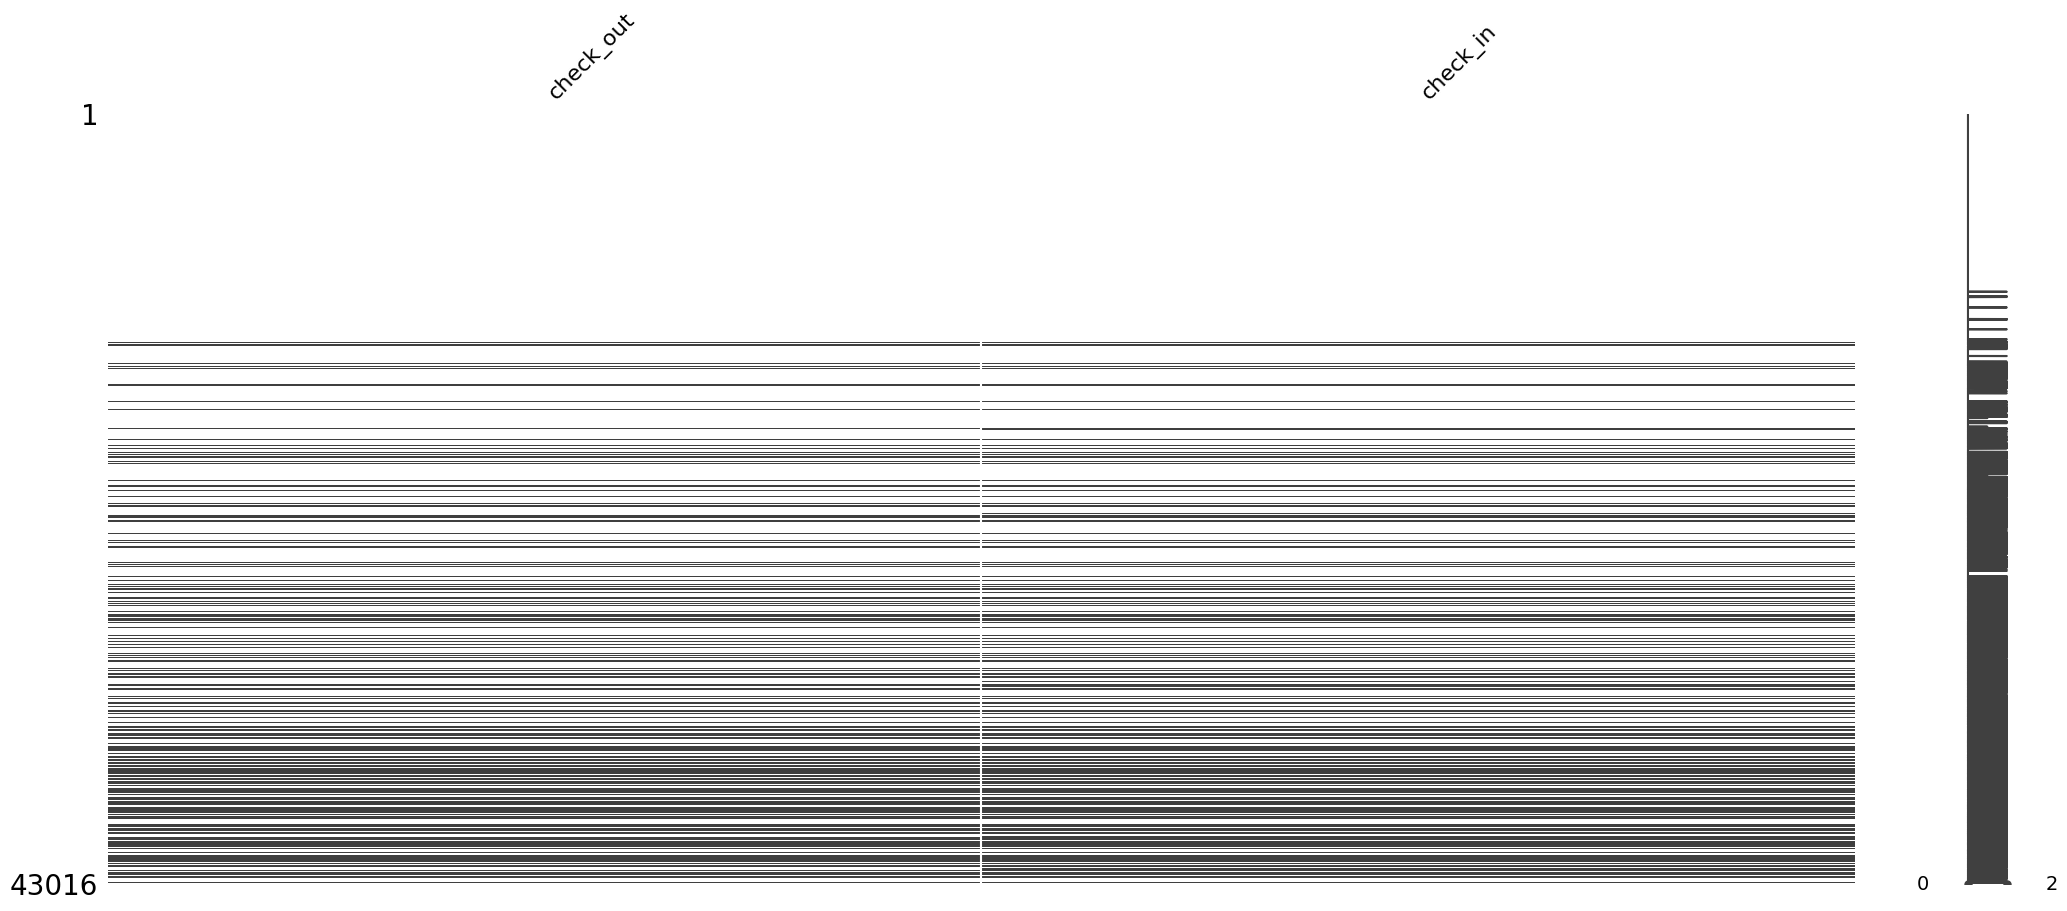

In [18]:
# Visualizing the missing values in the jobs dataset:
import missingno as msno

# Create a subset DataFrame with only 'check_out' and 'check_in' columns
subset_df = jobs.sort_values(by='created_at')
subset_df = jobs[['check_out', 'check_in']]
print("Count NaN: \n", subset_df.isnull().sum(), "\n")
print("Count Values: \n", subset_df.count())

# Visualize the missing data
msno.matrix(subset_df)

**Insights:**

- There is no records of check ins and outs in jobs database at the begining
- There are around 400 of check_outs absent


In [19]:
jobs["event_id"].nunique()

1562

In [20]:
# Finding first not NaN value in the 'check_out' column
first_not_nan_index = jobs['check_out'].first_valid_index()
jobs.loc[first_not_nan_index]

,9930
id,21263
event_id,923
type,2
area_id,NaN
stand_id,5767.0
stand_position_id,NaN
employee_id,1552.0
created_at,2023-10-13 18:45:11.143000+00:00
updated_at,2023-10-14 22:36:24.749000+00:00
deleted_at,NaT


**Insights:**

- Since our first "check_out" record happened at 2023-10-13, we will disregard all other data


## 3.7 Finding Consistent Event Data for Building Model


The number of events with 0% show up rate: 
 427 

Describing Events' Records Ratio (Show Up Rate): 
 0.7082679173063882 

sufficient_records
True     566
False    427
Name: count, dtype: int64


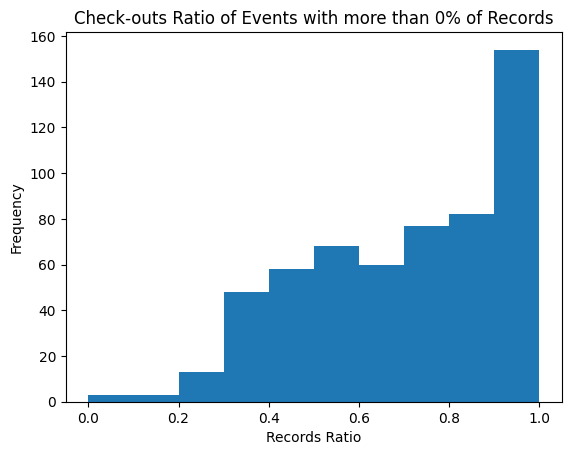

Describe the records of events that have +0% of check_ins and check_outs: 
                  id      event_id          type      area_id      stand_id  \
count  18449.000000  18449.000000  18449.000000   247.000000   1429.000000   
mean   31243.383761   1215.019134      2.769744  1160.680162   6957.840448   
std     8241.136691    297.639265      0.675341   245.782852   1364.414500   
min    12720.000000    503.000000      0.000000   664.000000   3235.000000   
25%    24879.000000    979.000000      3.000000  1029.500000   6307.000000   
50%    32935.000000   1149.000000      3.000000  1179.000000   6945.000000   
75%    38221.000000   1404.000000      3.000000  1295.500000   7690.000000   
max    43400.000000   1864.000000      3.000000  1965.000000  10601.000000   

       stand_position_id   employee_id  
count       15998.000000  18449.000000  
mean         7756.633579   5262.766275  
std          2080.061185   3132.414380  
min          2605.000000      4.000000  
25%          632

In [21]:
# Find how many events that have +50% of check_ins and check_outs --> diregard other events
jobs_filtered = jobs.loc[first_not_nan_index::, :]
jobs_filtered = jobs_filtered.groupby('event_id').agg({'check_out': 'count', 'created_at': 'count'})
jobs_filtered.reset_index(inplace=True)

# Filter the events that have +0% of check_ins and check_outs
jobs_filtered["records_ratio"] = jobs_filtered["check_out"] / jobs_filtered["created_at"]
print("The number of events with 0% show up rate: \n", jobs_filtered.loc[jobs_filtered["records_ratio"] == 0.0].shape[0], "\n")
jobs_filtered["sufficient_records"] = jobs_filtered["check_out"] > 0.0 * jobs_filtered["created_at"]
total_sufficient_ratio = jobs_filtered["sufficient_records"].value_counts()
ratio_df = jobs_filtered

# Describe the ratio of events that have +0% of record Events
print("Describing Events' Records Ratio (Show Up Rate): \n", jobs_filtered.loc[jobs_filtered["sufficient_records"] == True]["records_ratio"].mean(), "\n")

print(total_sufficient_ratio)
# Visualize the ratio of events of check_ins and check_outs in 10% bins historgram
import matplotlib.pyplot as plt

# Create a histogram of the records ratio
plt.hist(jobs_filtered.loc[jobs_filtered["records_ratio"] > 0.0]["records_ratio"], bins=10, range=(0, 1))

# Set the labels and title
plt.xlabel("Records Ratio")
plt.ylabel("Frequency")
plt.title("Check-outs Ratio of Events with more than 0% of Records")

# Show the plot
plt.show()

# Save changes to the jobs dataset
jobs_filtered = jobs_filtered[jobs_filtered['sufficient_records'] == True]
jobs_filtered = jobs[jobs["event_id"].isin(jobs_filtered["event_id"])]
jobs_filtered.describe()

# Describe the records of events that have +0% of check_ins and check_outs
print("Describe the records of events that have +0% of check_ins and check_outs: \n", jobs_filtered.describe(), "\n")

# Describe the size of the events that have +0% of check_ins and check_outs
print("Describing Size of +0% recorded Events: \n", jobs_filtered.groupby("event_id").size().describe(), "\n")



**Insights:**

- There are only 566 (out of 993) events with staff records above 0%
- Selected +0% records Events have ~70% show up rate
- Total number of Selected records to analyze is 18,449
- Average number of staff per event is ~32


## 3.8 Looking into attendance_status of before the event


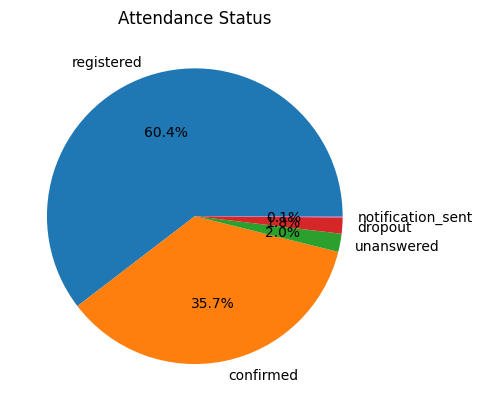

In [22]:
# Visualizing the distribution of attendance_status

import matplotlib.pyplot as plt

# Select random employee_event['attendance_status']
random_attendance_status = employee_event['attendance_status']

# Count the occurrences of each attendance status
attendance_counts = random_attendance_status.value_counts()

# Create a pie chart
plt.pie(attendance_counts, labels=attendance_counts.index, autopct='%1.1f%%')
plt.title("Attendance Status")
plt.show()

The number of total ['dropout', 'unanswered', 'notification_sent']: 1780 / 45854


Text(0.5, 1.0, 'No-Show/Other Strike Rate')

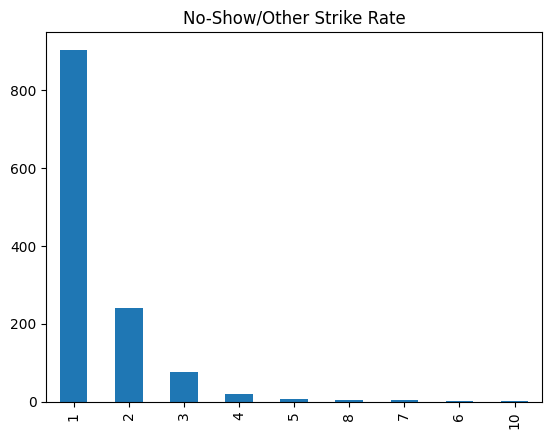

In [23]:
# Visualizing the dropout rate of employees before the event
employee_event_test = employee_event.copy()
employee_event_test = employee_event_test.sort_values(by='created_at', ascending=False)
employee_event_test = employee_event_test.loc[employee_event_test['attendance_status'].isin(['dropout', 'unanswered', 'notification_sent'])]
print("The number of total ['dropout', 'unanswered', 'notification_sent']:", employee_event_test.shape[0] ,'/',employee_event.shape[0])

employee_event_test.groupby('employee_id').size().value_counts().plot(kind='bar')
plt.title('No-Show/Other Strike Rate')


**Insights:**

- There are not many cases of 'dropout', 'unanswered', and 'notification_sent'attendance status (~5%) before the event.
- The number of repiting no-show or similar attendance status is extreemly low, but still happens. Now probably even more low due to "No Toleration to No-Show" policy


## 4. EDA with Visualization


Exploratory Data Analysis to identify drivers for the no-show prediction


## 4.1 Create one dataframe with all most important features


Features for our model will be broken up into following groups and subgroups:

1. Employee
   - e_e: attendance_status (5 categories)
   - e_e: position_preference (T/F)
   - e_e: employee_preference (T/F)
   - e_e: stand_preference (T/F)
   - jobs: has_finished (T/F) (no need to use it due to the check_out values)
   - jobs: warnings (engineer) (find other way to find it --> use warnings )
   - employees: time_since_account_created (engineer)
   - e_e: num_of_events_worked (engineer)
   - e_e: time_since_last_event (engineer)
   - employees: uniform_status (4 categories) (show its distribution)
2. Event
   - jobs: type (4 categories)
   - jobs: area_id (341 categories)
   - jobs: stand_id (4037 categories is too much, so we will drop it)
   - events: employee_capacity (make it numerical feature)
   - !!! events: buffer (use it later for cost analysis of the model)
3. Outside Factors
   - internet: hype (engineer) (based on online bets and tickets sold/prices)
   - internet: traffic (engineer) (find something)


## 4.1.1 Building a show_up_df as the main df for Logistic Regression


In [24]:
jobs_filtered.head()

,id,event_id,type,area_id,stand_id,stand_position_id,employee_id,created_at,updated_at,deleted_at,check_in,check_out,check_out_description,has_finished
1669,24579,981,3,NaN,NaN,6609.0,4834.0,2023-11-01 06:00:05.933000+00:00,2023-11-01 06:00:05.934000+00:00,NaT,NaT,NaT,NaN,False
4863,24580,981,3,NaN,NaN,6609.0,5845.0,2023-11-01 06:00:05.940000+00:00,2023-11-01 06:00:05.941000+00:00,NaT,NaT,NaT,NaN,False
9930,21263,923,2,NaN,5767.0,NaN,1552.0,2023-10-13 18:45:11.143000+00:00,2023-10-14 22:36:24.749000+00:00,NaT,2023-10-14 14:32:55+00:00,2023-10-14 22:35:57+00:00,NaN,False
10162,24581,981,3,NaN,NaN,6609.0,8213.0,2023-11-01 06:00:05.944000+00:00,2023-11-01 06:00:05.946000+00:00,NaT,NaT,NaT,NaN,False
10169,22037,987,3,NaN,NaN,5986.0,8055.0,2023-10-19 05:11:14.668000+00:00,2023-11-01 13:37:22.608000+00:00,2023-10-26 13:36:50.711000+00:00,NaT,NaT,NaN,False


Text(0.5, 1.0, 'Show Up Rate')

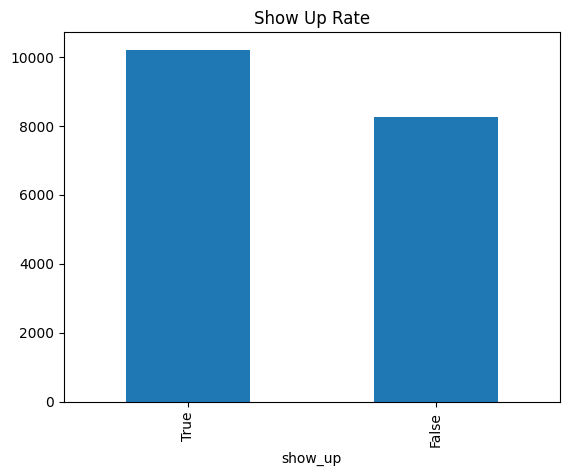

In [25]:
# Let's see the distribution of the "show_up" rate
show_up_df = jobs_filtered.copy().sort_values(by='created_at', ascending=False)
show_up_df["show_up"] = jobs_filtered["check_out"].notnull()
show_up_df["show_up"].value_counts().plot(kind='bar')
plt.title('Show Up Rate')



In [26]:
# Let's see all the columns:
show_up_df.head()

,id,event_id,type,area_id,stand_id,stand_position_id,employee_id,created_at,updated_at,deleted_at,check_in,check_out,check_out_description,has_finished,show_up
43013,43400,1806,3,NaN,NaN,12035.0,515.0,2024-05-16 16:56:54.722000+00:00,2024-05-17 01:47:12.538000+00:00,NaT,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,NaN,False,True
43011,43397,1806,3,NaN,NaN,11543.0,8564.0,2024-05-16 14:37:25.570000+00:00,2024-05-17 01:21:55.315000+00:00,NaT,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,NaN,False,True
42996,43395,1564,3,NaN,NaN,12012.0,9957.0,2024-05-16 14:26:15.041000+00:00,2024-05-16 14:26:15.042000+00:00,NaT,NaT,NaT,NaN,False,False
43000,43394,1506,3,NaN,NaN,9190.0,9931.0,2024-05-16 13:56:07.708000+00:00,2024-05-16 17:22:34.659000+00:00,NaT,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,NaN,False,True
42995,43381,1506,0,NaN,NaN,NaN,2944.0,2024-05-15 21:53:32.494000+00:00,2024-05-16 13:55:57.776000+00:00,2024-04-16 21:13:20.436000+00:00,NaT,NaT,NaN,False,False


In [27]:
# Let's drop the unnecessary columns:
show_up_df.drop(columns=['stand_id', 'stand_position_id', 'updated_at', 'deleted_at', 'check_out_description', 'has_finished'], inplace=True)
show_up_df.head()

,id,event_id,type,area_id,employee_id,created_at,check_in,check_out,show_up
43013,43400,1806,3,NaN,515.0,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True
43011,43397,1806,3,NaN,8564.0,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True
42996,43395,1564,3,NaN,9957.0,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False
43000,43394,1506,3,NaN,9931.0,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True
42995,43381,1506,0,NaN,2944.0,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False


## 4.1.2 Let's Add Employee Features

Employee

- e_e: attendance_status (5 categories)
- e_e: position_preference (T/F)
- e_e: employee_preference (T/F)
- e_e: stand_preference (T/F)
- jobs: has_finished (T/F) (no need to use it due to the check_out values)
- jobs: warnings (engineer) (find other way to find it --> use warnings )
- jobs: time_passed_report_time
- employees: time_since_account_created (engineer)
- e_e: num_of_events_worked (engineer)
- e_e: time_since_last_event (engineer)
- employees: uniform_status (4 categories) (show its distribution)


In [28]:
# Let's see columns of the show_up_df dataset:
show_up_df.tail()

,id,event_id,type,area_id,employee_id,created_at,check_in,check_out,show_up
12743,12724,503,3,NaN,320.0,2023-07-14 14:38:22.160000+00:00,2023-07-14 20:33:00+00:00,2023-07-19 01:31:00+00:00,True
12747,12723,503,3,NaN,1196.0,2023-07-14 14:38:22.155000+00:00,2023-07-14 19:00:00+00:00,2023-07-19 01:31:00+00:00,True
12736,12722,503,3,NaN,3149.0,2023-07-14 14:38:22.150000+00:00,2023-07-14 20:14:00+00:00,2023-07-19 01:31:00+00:00,True
12728,12721,503,3,NaN,3213.0,2023-07-14 14:38:22.145000+00:00,2023-07-14 20:15:00+00:00,2023-07-19 01:32:00+00:00,True
12741,12720,503,2,NaN,3751.0,2023-07-14 14:36:30.757000+00:00,2023-07-14 19:30:00+00:00,2023-07-19 01:30:00+00:00,True


In [29]:
# Let's see columns of the employee_event dataset:
employee_event.head()

,employee_id,event_id,created_at,updated_at,deleted_at,attendance_status,position_preference,employee_preference,stand_preference
0,507,5,2022-09-05 16:41:06,2022-09-05 16:41:06,NaT,registered,NaN,NaN,NaN
1,632,5,2022-09-05 16:42:00,2022-09-05 16:42:00,NaT,registered,NaN,NaN,NaN
2,392,5,2022-09-05 16:43:22,2022-09-05 16:43:22,NaT,registered,NaN,NaN,NaN
3,668,5,2022-09-05 16:44:48,2022-09-05 16:44:48,NaT,registered,NaN,NaN,NaN
4,754,5,2022-09-05 16:48:07,2022-09-05 16:48:07,NaT,registered,NaN,NaN,NaN


In [30]:
# Starting with the employee_event dataset, we will merge the datasets to get the final dataset for modeling
# Merge the employee_event and show_up_df datasets
final_df_employee_factors = pd.merge(show_up_df, employee_event, on=['event_id', 'employee_id'], how='left', suffixes=["_jobs", "_employee_event"])

# Drop unnecessary columns
final_df_employee_factors.drop(columns=['created_at_employee_event', 'updated_at', 'deleted_at'], inplace=True)
final_df_employee_factors.tail()


,id,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference
18444,12724,503,3,NaN,320.0,2023-07-14 14:38:22.160000+00:00,2023-07-14 20:33:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN
18445,12723,503,3,NaN,1196.0,2023-07-14 14:38:22.155000+00:00,2023-07-14 19:00:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN
18446,12722,503,3,NaN,3149.0,2023-07-14 14:38:22.150000+00:00,2023-07-14 20:14:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN
18447,12721,503,3,NaN,3213.0,2023-07-14 14:38:22.145000+00:00,2023-07-14 20:15:00+00:00,2023-07-19 01:32:00+00:00,True,registered,NaN,NaN,NaN
18448,12720,503,2,NaN,3751.0,2023-07-14 14:36:30.757000+00:00,2023-07-14 19:30:00+00:00,2023-07-19 01:30:00+00:00,True,registered,NaN,NaN,NaN


In [31]:
# Let's feature engineer "num_of_events_worked" feature:
final_df_employee_factors['num_of_events_worked'] = final_df_employee_factors.groupby('employee_id')['event_id'].transform('count')
final_df_employee_factors.head()

,id,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked
0,43400,1806,3,NaN,515.0,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True,confirmed,NaN,NaN,NaN,81
1,43397,1806,3,NaN,8564.0,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True,confirmed,NaN,NaN,NaN,47
2,43395,1564,3,NaN,9957.0,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False,notification_sent,NaN,NaN,NaN,2
3,43394,1506,3,NaN,9931.0,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True,registered,NaN,NaN,NaN,1
4,43381,1506,0,NaN,2944.0,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False,registered,NaN,NaN,NaN,37


In [32]:
# Let's see the "num_of_events_worked" feature for one employee:
final_df_employee_factors.loc[final_df_employee_factors['employee_id'] == 6804].sort_values(by='created_at_jobs', ascending=False).head(10)

,id,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked
45,43334,1850,3,NaN,6804.0,2024-05-15 05:15:30.350000+00:00,2024-05-11 18:24:00+00:00,2024-05-12 02:25:00+00:00,True,confirmed,NaN,NaN,NaN,14
292,42878,1712,3,NaN,6804.0,2024-05-08 18:14:09.702000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,14
4400,38438,1604,3,NaN,6804.0,2024-03-01 23:35:18.666000+00:00,2024-03-02 14:15:00+00:00,2024-03-02 18:15:00+00:00,True,registered,NaN,NaN,NaN,14
6982,35842,1106,3,NaN,6804.0,2024-02-03 03:07:26.272000+00:00,2024-02-03 18:10:09+00:00,2024-02-04 01:44:55+00:00,True,confirmed,12.0,1616.0,6299.0,14
8919,33427,1103,3,NaN,6804.0,2023-12-30 05:00:40.011000+00:00,NaT,NaT,False,confirmed,12.0,1616.0,6279.0,14
9851,31378,989,3,NaN,6804.0,2023-11-28 15:11:54.129000+00:00,2023-11-25 14:19:43+00:00,NaT,False,confirmed,NaN,NaN,NaN,14
10949,29785,989,2,NaN,6804.0,2023-11-20 01:33:23.228000+00:00,2023-11-25 14:19:43+00:00,NaT,False,confirmed,NaN,NaN,NaN,14
11229,29355,989,3,NaN,6804.0,2023-11-16 18:20:14.515000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,14
14825,23102,1091,3,NaN,6804.0,2023-10-23 22:00:16.393000+00:00,NaT,NaT,False,confirmed,12.0,NaN,NaN,14
14966,22910,986,3,NaN,6804.0,2023-10-23 17:28:07.262000+00:00,NaT,NaT,False,confirmed,12.0,NaN,5845.0,14


TODO:

- why there is a douplicate of 1205 event_id and 7642.0 employee_id


In [33]:
# Let's feature engineer "time_since_last_event" feature:
today = datetime.now().date()
final_df_employee_factors['time_since_last_event'] = final_df_employee_factors.groupby('employee_id')['created_at_jobs'].transform(lambda x: today - x.max().date())
final_df_employee_factors.tail()


,id,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event
18444,12724,503,3,NaN,320.0,2023-07-14 14:38:22.160000+00:00,2023-07-14 20:33:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,6,167 days 00:00:00
18445,12723,503,3,NaN,1196.0,2023-07-14 14:38:22.155000+00:00,2023-07-14 19:00:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,5,354 days 00:00:00
18446,12722,503,3,NaN,3149.0,2023-07-14 14:38:22.150000+00:00,2023-07-14 20:14:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,37,82 days 00:00:00
18447,12721,503,3,NaN,3213.0,2023-07-14 14:38:22.145000+00:00,2023-07-14 20:15:00+00:00,2023-07-19 01:32:00+00:00,True,registered,NaN,NaN,NaN,35,79 days 00:00:00
18448,12720,503,2,NaN,3751.0,2023-07-14 14:36:30.757000+00:00,2023-07-14 19:30:00+00:00,2023-07-19 01:30:00+00:00,True,registered,NaN,NaN,NaN,4,179 days 00:00:00


In [34]:
# Let's see the "time_since_last_event" feature for one employee:
final_df_employee_factors.loc[final_df_employee_factors['employee_id'] == 6804].sort_values(by='created_at_jobs', ascending=False).head(10)

,id,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event
45,43334,1850,3,NaN,6804.0,2024-05-15 05:15:30.350000+00:00,2024-05-11 18:24:00+00:00,2024-05-12 02:25:00+00:00,True,confirmed,NaN,NaN,NaN,14,79 days 00:00:00
292,42878,1712,3,NaN,6804.0,2024-05-08 18:14:09.702000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,14,79 days 00:00:00
4400,38438,1604,3,NaN,6804.0,2024-03-01 23:35:18.666000+00:00,2024-03-02 14:15:00+00:00,2024-03-02 18:15:00+00:00,True,registered,NaN,NaN,NaN,14,79 days 00:00:00
6982,35842,1106,3,NaN,6804.0,2024-02-03 03:07:26.272000+00:00,2024-02-03 18:10:09+00:00,2024-02-04 01:44:55+00:00,True,confirmed,12.0,1616.0,6299.0,14,79 days 00:00:00
8919,33427,1103,3,NaN,6804.0,2023-12-30 05:00:40.011000+00:00,NaT,NaT,False,confirmed,12.0,1616.0,6279.0,14,79 days 00:00:00
9851,31378,989,3,NaN,6804.0,2023-11-28 15:11:54.129000+00:00,2023-11-25 14:19:43+00:00,NaT,False,confirmed,NaN,NaN,NaN,14,79 days 00:00:00
10949,29785,989,2,NaN,6804.0,2023-11-20 01:33:23.228000+00:00,2023-11-25 14:19:43+00:00,NaT,False,confirmed,NaN,NaN,NaN,14,79 days 00:00:00
11229,29355,989,3,NaN,6804.0,2023-11-16 18:20:14.515000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,14,79 days 00:00:00
14825,23102,1091,3,NaN,6804.0,2023-10-23 22:00:16.393000+00:00,NaT,NaT,False,confirmed,12.0,NaN,NaN,14,79 days 00:00:00
14966,22910,986,3,NaN,6804.0,2023-10-23 17:28:07.262000+00:00,NaT,NaT,False,confirmed,12.0,NaN,5845.0,14,79 days 00:00:00


In [35]:
# Let's feature engineer "time_passed_report_time" feature:

# 1. Add "time_passed_report_time" and other features from the events dataset to the final_df_employee_factors:
final_df_employee_factors = pd.merge(final_df_employee_factors, events[['id', 'report_time']], left_on='event_id', right_on="id", how='left', suffixes=["_jobs", "_events"])

final_df_employee_factors['time_passed_report_time'] = pd.to_datetime(final_df_employee_factors['check_in'], format='%H:%M:%S') - pd.to_datetime(final_df_employee_factors['report_time'], format='%H:%M:%S')

final_df_employee_factors.tail()

,id_jobs,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time
18444,12724,503,3,NaN,320.0,2023-07-14 14:38:22.160000+00:00,2023-07-14 20:33:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,6,167 days 00:00:00,503,2023-06-14 20:00:00+00:00,30 days 00:33:00
18445,12723,503,3,NaN,1196.0,2023-07-14 14:38:22.155000+00:00,2023-07-14 19:00:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,5,354 days 00:00:00,503,2023-06-14 20:00:00+00:00,29 days 23:00:00
18446,12722,503,3,NaN,3149.0,2023-07-14 14:38:22.150000+00:00,2023-07-14 20:14:00+00:00,2023-07-19 01:31:00+00:00,True,registered,NaN,NaN,NaN,37,82 days 00:00:00,503,2023-06-14 20:00:00+00:00,30 days 00:14:00
18447,12721,503,3,NaN,3213.0,2023-07-14 14:38:22.145000+00:00,2023-07-14 20:15:00+00:00,2023-07-19 01:32:00+00:00,True,registered,NaN,NaN,NaN,35,79 days 00:00:00,503,2023-06-14 20:00:00+00:00,30 days 00:15:00
18448,12720,503,2,NaN,3751.0,2023-07-14 14:36:30.757000+00:00,2023-07-14 19:30:00+00:00,2023-07-19 01:30:00+00:00,True,registered,NaN,NaN,NaN,4,179 days 00:00:00,503,2023-06-14 20:00:00+00:00,29 days 23:30:00


In [36]:
# Let's see the "time_passed_report_time" feature for one employee:
final_df_employee_factors.loc[final_df_employee_factors['employee_id'] == 6704].sort_values(by='created_at_jobs', ascending=False).head(10)

,id_jobs,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time
4474,38364,1395,3,NaN,6704.0,2024-03-01 21:17:07.584000+00:00,2024-03-05 21:55:09+00:00,2024-03-06 01:45:14+00:00,True,confirmed,13.0,NaN,7872.0,1,154 days 00:00:00,1395,2024-03-05 22:00:00+00:00,-1 days +23:55:09


In [37]:
final_df_employee_factors["time_passed_report_time"].describe()

,time_passed_report_time
count,10477
mean,0 days 23:25:53.199675479
std,4 days 15:21:41.147657669
min,-6 days +23:50:00
25%,-1 days +23:45:11
50%,0 days 00:06:48
75%,0 days 00:34:14
max,44 days 23:00:43


In [38]:
# Filter out null values and late time < 1h:
hour_passed = final_df_employee_factors["time_passed_report_time"].dropna()
hour_passed = final_df_employee_factors[(final_df_employee_factors["time_passed_report_time"] < pd.Timedelta(hours=1)) & (final_df_employee_factors["time_passed_report_time"] > pd.Timedelta(hours=0))]["time_passed_report_time"]
hour_passed.describe()

,time_passed_report_time
count,4269
mean,0 days 00:18:41.406418364
std,0 days 00:14:25.404583815
min,0 days 00:00:01
25%,0 days 00:07:20
50%,0 days 00:15:35
75%,0 days 00:27:05
max,0 days 00:59:59


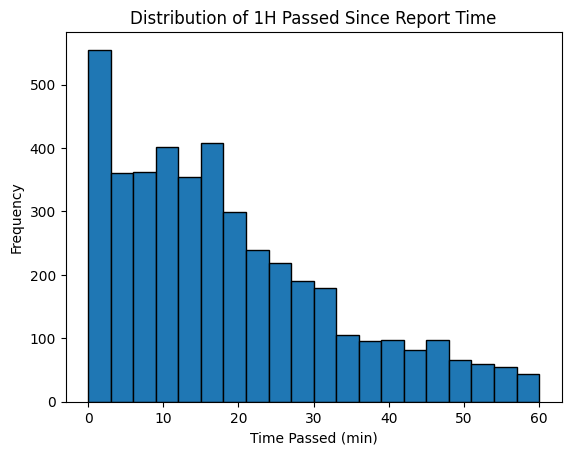

In [39]:
import matplotlib.pyplot as plt

# Convert timedelta to hours
time_late_min = hour_passed.dt.total_seconds() / 60

# Create histogram
plt.hist(time_late_min, bins=20, edgecolor='black')

# Set labels and title
plt.xlabel("Time Passed (min)")
plt.ylabel("Frequency")
plt.title("Distribution of 1H Passed Since Report Time")

# Display the graph
plt.show()

In [40]:
# Filter out null values and late time < 1h:
time_early = final_df_employee_factors["time_passed_report_time"].dropna()
time_early = final_df_employee_factors[(final_df_employee_factors["time_passed_report_time"] <= pd.Timedelta(hours=0))]["time_passed_report_time"]
time_early.describe()

,time_passed_report_time
count,4247
mean,-1 days +22:48:46.156816577
std,0 days 07:19:33.574821507
min,-6 days +23:50:00
25%,-1 days +23:11:59.500000
50%,-1 days +23:37:51
75%,-1 days +23:52:00
max,0 days 00:00:00


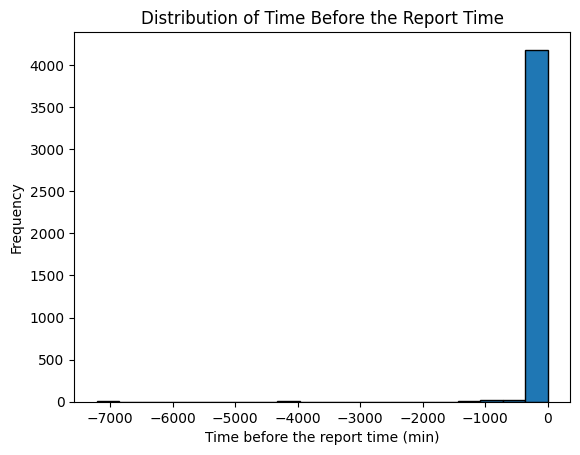

In [41]:
import matplotlib.pyplot as plt

# Convert timedelta to hours
time_early_min = time_early.dt.total_seconds() / 60

# Create histogram
plt.hist(time_early_min, bins=20, edgecolor='black')

# Set labels and title
plt.xlabel("Time before the report time (min)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Before the Report Time")

# Display the graph
plt.show()

In [42]:
# Filter out null values and late time > 1h late:
time_passed_hour = final_df_employee_factors["time_passed_report_time"].dropna()
time_passed_hour = final_df_employee_factors[(final_df_employee_factors["time_passed_report_time"] >= pd.Timedelta(hours=1))]["time_passed_report_time"]
time_passed_hour.describe()

,time_passed_report_time
count,1961
mean,5 days 07:04:47.098929117
std,9 days 14:05:26.203121645
min,0 days 01:00:00
25%,0 days 01:40:00
50%,0 days 13:00:00
75%,3 days 00:06:01
max,44 days 23:00:43


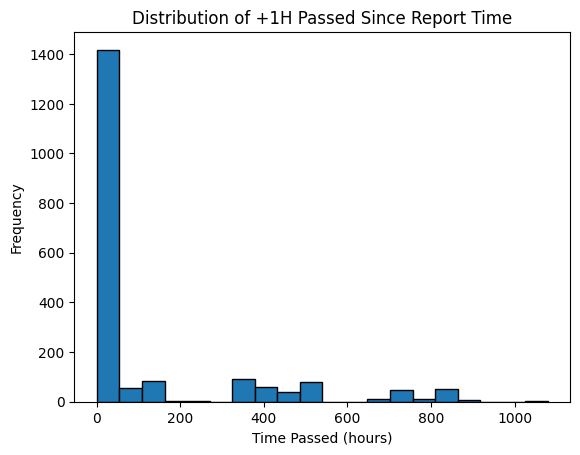

In [43]:
import matplotlib.pyplot as plt

# Convert timedelta to hours
time_passed_hours = time_passed_hour.dt.total_seconds() / 3600

# Create histogram
plt.hist(time_passed_hours, bins=20, edgecolor='black')

# Set labels and title
plt.xlabel("Time Passed (hours)")
plt.ylabel("Frequency")
plt.title("Distribution of +1H Passed Since Report Time")

# Display the graph
plt.show()

In [44]:
print("The number of employees records for the analysis is: ", final_df_employee_factors["time_passed_report_time"].shape[0], "\n")
print("The number of employees with checked-in info for the analysis is: ", final_df_employee_factors["time_passed_report_time"].dropna().shape[0])


The number of employees records for the analysis is:  18449 

The number of employees with checked-in info for the analysis is:  10477


Insights:

1. The number of employees passed report time within 1h is 4,269
2. The number of employees came before or at the report time is 4,247
3. The number of employees came after 1h late is 1,961
4. The number of the checked out emplyees for the analysis is 10,477 / 18,449


In [45]:
# Let's feature engineer "warnings_points" for final_df_employee_factors:

# Create a feature for warnings point system
warnings_points_system = {"Tardy":                  1,
                          "Drop Out":               3,
                          "Other":                  3,
                          "Uniform":                1,
                          "Behavioral Incident":    3,
                          "Alcohol Violation":      10,
                          "Venue Complaint":        3
                          }

warnings["warnings_points"] = warnings["warning_type"].map(warnings_points_system)
grouped_warnings = warnings.groupby("recipient_id")["warnings_points"].sum().reset_index()

# Add a "warnings_points" feature to final_df_employee_factors
final_df_employee_factors = pd.merge(final_df_employee_factors, grouped_warnings, left_on='employee_id', right_on="recipient_id", how='left', suffixes=["_jobs", "_warnings"])
final_df_employee_factors.head()



,id_jobs,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time,recipient_id,warnings_points
0,43400,1806,3,NaN,515.0,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True,confirmed,NaN,NaN,NaN,81,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:38:20,NaN,NaN
1,43397,1806,3,NaN,8564.0,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:58:12,8564.0,2.0
2,43395,1564,3,NaN,9957.0,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False,notification_sent,NaN,NaN,NaN,2,78 days 00:00:00,1564,2024-05-16 20:00:00+00:00,NaT,NaN,NaN
3,43394,1506,3,NaN,9931.0,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True,registered,NaN,NaN,NaN,1,78 days 00:00:00,1506,2024-05-15 20:30:00+00:00,0 days 00:30:00,NaN,NaN
4,43381,1506,0,NaN,2944.0,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False,registered,NaN,NaN,NaN,37,79 days 00:00:00,1506,2024-05-15 20:30:00+00:00,NaT,NaN,NaN


In [46]:
# let's check one recipient:
final_df_employee_factors.loc[final_df_employee_factors['recipient_id'] == 8564].sort_values(by="event_id", ascending=True,).head(20)

,id_jobs,event_id,type,area_id,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time,recipient_id,warnings_points
14026,24645,939,3,NaN,8564.0,2023-11-01 10:58:06.171000+00:00,2023-11-04 15:16:34+00:00,2023-11-04 21:11:28+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,939,2023-11-04 15:30:00+00:00,-1 days +23:46:34,8564.0,2.0
13058,26381,939,3,NaN,8564.0,2023-11-07 16:45:28.596000+00:00,2023-11-04 15:16:34+00:00,2023-11-04 21:11:28+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,939,2023-11-04 15:30:00+00:00,-1 days +23:46:34,8564.0,2.0
10421,30581,941,3,NaN,8564.0,2023-11-22 17:33:47.690000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,941,2023-11-25 17:30:00+00:00,NaT,8564.0,2.0
10304,30743,941,3,NaN,8564.0,2023-11-24 14:48:11.561000+00:00,2023-11-25 16:55:52+00:00,2023-11-27 23:33:03+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,941,2023-11-25 17:30:00+00:00,-1 days +23:25:52,8564.0,2.0
9801,31463,941,3,NaN,8564.0,2023-11-28 16:56:19.486000+00:00,NaT,NaT,False,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,941,2023-11-25 17:30:00+00:00,NaT,8564.0,2.0
12863,26614,1131,3,NaN,8564.0,2023-11-07 23:56:31.723000+00:00,2023-11-10 21:28:17+00:00,2023-11-11 03:35:01+00:00,True,confirmed,12.0,NaN,NaN,47,78 days 00:00:00,1131,2023-11-10 21:30:00+00:00,-1 days +23:58:17,8564.0,2.0
11995,28192,1135,3,NaN,8564.0,2023-11-14 01:23:34.785000+00:00,2023-11-14 21:34:40+00:00,2023-11-15 01:42:46+00:00,True,registered,NaN,NaN,NaN,47,78 days 00:00:00,1135,2023-11-14 22:00:00+00:00,-1 days +23:34:40,8564.0,2.0
10889,29873,1135,3,NaN,8564.0,2023-11-20 18:43:58.457000+00:00,2023-11-14 21:34:40+00:00,2023-11-15 01:42:46+00:00,True,registered,NaN,NaN,NaN,47,78 days 00:00:00,1135,2023-11-14 22:00:00+00:00,-1 days +23:34:40,8564.0,2.0
11196,29402,1136,3,NaN,8564.0,2023-11-16 21:53:49.073000+00:00,2023-11-16 21:47:00+00:00,2023-11-17 01:41:20+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1136,2023-10-31 21:00:00+00:00,16 days 00:47:00,8564.0,2.0
10819,29971,1136,3,NaN,8564.0,2023-11-20 19:36:31.712000+00:00,2023-11-16 21:47:00+00:00,2023-11-17 01:41:20+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1136,2023-10-31 21:00:00+00:00,16 days 00:47:00,8564.0,2.0


In [47]:
warnings.loc[warnings['recipient_id'] == 8564].head(20)

,id,recipient_id,warning_type,warning,event_id,created_at,warnings_points
231,1095,8564,Tardy,You arrived later than 30 minutes of the desig...,1562,2024-05-08 00:58:05.797000+00:00,1
478,554,8564,Tardy,You arrived later than 30 minutes of the desig...,1555,2024-04-20 02:30:32.819000+00:00,1


TODO:

1. Warnings for event_id does not always match to jobs event_id or recipient_id does not match to employee_id (ex. 8564 employee_id)


## 4.1.3 Let's Add Event Features

Event

- jobs: type (4 categories)
- jobs: area_id (341 categories)
- jobs: stand_id (4037 categories is too much, so we will drop it)
- events: employee_capacity (make it numerical feature)
- !!! events: buffer (use it later for cost analysis of the model)


In [48]:
# Already added features jobs: type, area_id, and stand_id
print("The number of unique type:", final_df_employee_factors['type'].nunique(), "\n")
print("The number of unique area_id:", final_df_employee_factors['area_id'].nunique(), "\n")

print("The number of type:",final_df_employee_factors["type"].count(), "\n")
print("The number of area_id:",final_df_employee_factors["area_id"].count(), "\n")

# We will drop area_id as there is not enough data for our prediction model:
final_df_employee_factors.drop(columns=['area_id'], inplace=True)



The number of unique type: 4 

The number of unique area_id: 183 

The number of type: 18449 

The number of area_id: 247 



In [49]:
# Adding "event_employee_capacity":
final_df_employee_factors = pd.merge(final_df_employee_factors, events[['id', 'employee_capacity']], left_on='event_id', right_on="id", how='left', suffixes=["_jobs", "_events"])
final_df_employee_factors.head()

,id_jobs,event_id,type,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time,recipient_id,warnings_points,id,employee_capacity
0,43400,1806,3,515.0,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True,confirmed,NaN,NaN,NaN,81,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:38:20,NaN,NaN,1806,18.0
1,43397,1806,3,8564.0,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:58:12,8564.0,2.0,1806,18.0
2,43395,1564,3,9957.0,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False,notification_sent,NaN,NaN,NaN,2,78 days 00:00:00,1564,2024-05-16 20:00:00+00:00,NaT,NaN,NaN,1564,6.0
3,43394,1506,3,9931.0,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True,registered,NaN,NaN,NaN,1,78 days 00:00:00,1506,2024-05-15 20:30:00+00:00,0 days 00:30:00,NaN,NaN,1506,12.0
4,43381,1506,0,2944.0,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False,registered,NaN,NaN,NaN,37,79 days 00:00:00,1506,2024-05-15 20:30:00+00:00,NaT,NaN,NaN,1506,12.0


## 4.1.4 Let's Add Outside Factors Features

Outside Factors

- internet: hype (engineer) (based on online bets and tickets sold/prices)
- internet: traffic (engineer) (find something)

TODO: add outside factors features


In [50]:
# We will ignore Outside Factors for now

## 5 Feature Engineering and fixing/normalizing all features:


In [51]:
final_df = final_df_employee_factors.copy()
final_df["employee_id"] = final_df["employee_id"].astype(int)
final_df["type"] = final_df["type"].astype('category')
final_df["time_passed_report_time"] = final_df["time_passed_report_time"].astype('timedelta64[s]')
final_df["time_since_last_event"] = final_df["time_since_last_event"].astype('timedelta64[s]')
final_df.head()

,id_jobs,event_id,type,employee_id,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time,recipient_id,warnings_points,id,employee_capacity
0,43400,1806,3,515,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True,confirmed,NaN,NaN,NaN,81,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:38:20,NaN,NaN,1806,18.0
1,43397,1806,3,8564,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:58:12,8564.0,2.0,1806,18.0
2,43395,1564,3,9957,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False,notification_sent,NaN,NaN,NaN,2,78 days 00:00:00,1564,2024-05-16 20:00:00+00:00,NaT,NaN,NaN,1564,6.0
3,43394,1506,3,9931,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True,registered,NaN,NaN,NaN,1,78 days 00:00:00,1506,2024-05-15 20:30:00+00:00,0 days 00:30:00,NaN,NaN,1506,12.0
4,43381,1506,0,2944,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False,registered,NaN,NaN,NaN,37,79 days 00:00:00,1506,2024-05-15 20:30:00+00:00,NaT,NaN,NaN,1506,12.0


In [52]:
# Let's turn employee_id and event_id into indexes for final_df_employee_factors:
final_df.set_index(['employee_id', 'event_id'], inplace=True)
final_df.head()

,,id_jobs,type,created_at_jobs,check_in,check_out,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,id_events,report_time,time_passed_report_time,recipient_id,warnings_points,id,employee_capacity
employee_id,event_id,,,,,,,,,,,,,,,,,,,
515,1806,43400,3,2024-05-16 16:56:54.722000+00:00,2024-05-16 19:38:20+00:00,2024-05-17 01:47:12+00:00,True,confirmed,NaN,NaN,NaN,81,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:38:20,NaN,NaN,1806,18.0
8564,1806,43397,3,2024-05-16 14:37:25.570000+00:00,2024-05-16 19:58:12+00:00,2024-05-17 01:21:54+00:00,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,1806,2024-05-16 20:00:00+00:00,-1 days +23:58:12,8564.0,2.0,1806,18.0
9957,1564,43395,3,2024-05-16 14:26:15.041000+00:00,NaT,NaT,False,notification_sent,NaN,NaN,NaN,2,78 days 00:00:00,1564,2024-05-16 20:00:00+00:00,NaT,NaN,NaN,1564,6.0
9931,1506,43394,3,2024-05-16 13:56:07.708000+00:00,2024-05-15 21:00:00+00:00,2024-05-16 02:45:00+00:00,True,registered,NaN,NaN,NaN,1,78 days 00:00:00,1506,2024-05-15 20:30:00+00:00,0 days 00:30:00,NaN,NaN,1506,12.0
2944,1506,43381,0,2024-05-15 21:53:32.494000+00:00,NaT,NaT,False,registered,NaN,NaN,NaN,37,79 days 00:00:00,1506,2024-05-15 20:30:00+00:00,NaT,NaN,NaN,1506,12.0


In [53]:
# Let's drop unneccery features:
final_df.drop(columns=['id_jobs', 'created_at_jobs', 'check_in', 'check_out', 'id_events', 'report_time', 'recipient_id', 'id'], inplace=True)
final_df.head()

,,type,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,time_passed_report_time,warnings_points,employee_capacity
employee_id,event_id,,,,,,,,,,,
515,1806,3,True,confirmed,NaN,NaN,NaN,81,78 days 00:00:00,-1 days +23:38:20,NaN,18.0
8564,1806,3,True,confirmed,NaN,NaN,NaN,47,78 days 00:00:00,-1 days +23:58:12,2.0,18.0
9957,1564,3,False,notification_sent,NaN,NaN,NaN,2,78 days 00:00:00,NaT,NaN,6.0
9931,1506,3,True,registered,NaN,NaN,NaN,1,78 days 00:00:00,0 days 00:30:00,NaN,12.0
2944,1506,0,False,registered,NaN,NaN,NaN,37,79 days 00:00:00,NaT,NaN,12.0


In [54]:
# Let's normalize features by looking at NaN at each feature:
print("the number of not NaN:\n", final_df.count(), "\n")
print("the number of NaN:\n", final_df.isna().sum(), "\n")

the number of not NaN:
 type                       18449
show_up                    18449
attendance_status          17304
position_preference         5374
employee_preference         2196
stand_preference            3208
num_of_events_worked       18449
time_since_last_event      18449
time_passed_report_time    10477
warnings_points              855
employee_capacity          18080
dtype: int64 

the number of NaN:
 type                           0
show_up                        0
attendance_status           1145
position_preference        13075
employee_preference        16253
stand_preference           15241
num_of_events_worked           0
time_since_last_event          0
time_passed_report_time     7972
warnings_points            17594
employee_capacity            369
dtype: int64 



In [55]:
# Let's see "attendance_status" values count:
final_df["attendance_status"].value_counts(dropna=False)

,count
attendance_status,
confirmed,13898
registered,2800
NaN,1145
dropout,419
unanswered,186
notification_sent,1


In [56]:
# Let's make "position_preference" Boolean only:
final_df["position_preference"] = ~final_df["position_preference"].isna()
final_df["position_preference"].value_counts(dropna=False)

,count
position_preference,
False,13075
True,5374


In [57]:
# Let's make "position_preference" Boolean only:
final_df["employee_preference"] = ~final_df["employee_preference"].isna()
final_df["employee_preference"].value_counts(dropna=False)

,count
employee_preference,
False,16253
True,2196


In [58]:
# Let's make "stand_preference" Boolean only:
final_df["stand_preference"] = ~final_df["stand_preference"].isna()
final_df["stand_preference"].value_counts(dropna=False)

,count
stand_preference,
False,15241
True,3208


In [59]:
final_df["warnings_points"].describe()

,warnings_points
count,855.000000
mean,4.033918
std,4.248986
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,30.000000


In [60]:
# Show the of events with Employee Capacity NaN:
final_df[final_df["employee_capacity"].isna()].groupby("event_id").size()

,0
event_id,
503,35
511,14
512,25
513,21
516,17
517,15
518,23
519,22
520,23


In [61]:
# Droping rows with events without employee capacity values:
final_df.dropna(subset=["employee_capacity"], inplace=True)
final_df.shape

(18080, 11)

In [62]:
# Let's look at NaN at each feature:
print("the number of not NaN:\n", final_df.count(), "\n")
print("the number of NaN:\n", final_df.isna().sum(), "\n")

the number of not NaN:
 type                       18080
show_up                    18080
attendance_status          16936
position_preference        18080
employee_preference        18080
stand_preference           18080
num_of_events_worked       18080
time_since_last_event      18080
time_passed_report_time    10202
warnings_points              838
employee_capacity          18080
dtype: int64 

the number of NaN:
 type                           0
show_up                        0
attendance_status           1144
position_preference            0
employee_preference            0
stand_preference               0
num_of_events_worked           0
time_since_last_event          0
time_passed_report_time     7878
warnings_points            17242
employee_capacity              0
dtype: int64 



In [63]:
final_df["attendance_status"].unique()

['confirmed', 'notification_sent', 'registered', 'dropout', NaN, 'unanswered']
Categories (5, object): ['confirmed', 'dropout', 'notification_sent', 'registered', 'unanswered']

TODO:

1. How to account for warning points that are not frequent?


In [64]:
# Let's see attendance_status NaNs:
final_df[final_df["attendance_status"].isna()]["show_up"].value_counts()

,count
show_up,
False,1083
True,61


In [65]:
# Correcting the assignment for attendance_status
attendance_nan_show_up = final_df[final_df["attendance_status"].isna()]["show_up"]

final_df.loc[final_df["attendance_status"].isna() & (final_df["show_up"] == True), "attendance_status"] = "confirmed"
final_df.loc[final_df["attendance_status"].isna() & (final_df["show_up"] == False), "attendance_status"] = "unanswered"

# Correcting the assignment for time_passed_report_time
mean_time_passed = final_df["time_passed_report_time"].mean()
final_df.loc[final_df["time_passed_report_time"].isna(), "time_passed_report_time"] = mean_time_passed



In [66]:
# Let's fix NaN warnings_points to 0:
final_df["warnings_points"].fillna(0, inplace=True)

In [67]:
# Let's look at NaN at each feature:
print("the number of not NaN:\n", final_df.count(), "\n")
print("the number of NaN:\n", final_df.isna().sum(), "\n")

the number of not NaN:
 type                       18080
show_up                    18080
attendance_status          18080
position_preference        18080
employee_preference        18080
stand_preference           18080
num_of_events_worked       18080
time_since_last_event      18080
time_passed_report_time    18080
warnings_points            18080
employee_capacity          18080
dtype: int64 

the number of NaN:
 type                       0
show_up                    0
attendance_status          0
position_preference        0
employee_preference        0
stand_preference           0
num_of_events_worked       0
time_since_last_event      0
time_passed_report_time    0
warnings_points            0
employee_capacity          0
dtype: int64 



In [68]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18080 entries, (515, 1806) to (356, 1057)
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   type                     18080 non-null  category      
 1   show_up                  18080 non-null  bool          
 2   attendance_status        18080 non-null  category      
 3   position_preference      18080 non-null  bool          
 4   employee_preference      18080 non-null  bool          
 5   stand_preference         18080 non-null  bool          
 6   num_of_events_worked     18080 non-null  int64         
 7   time_since_last_event    18080 non-null  timedelta64[s]
 8   time_passed_report_time  18080 non-null  timedelta64[s]
 9   warnings_points          18080 non-null  float64       
 10  employee_capacity        18080 non-null  float64       
dtypes: bool(4), category(2), float64(2), int64(1), timedelta64[s](2)
memory usage

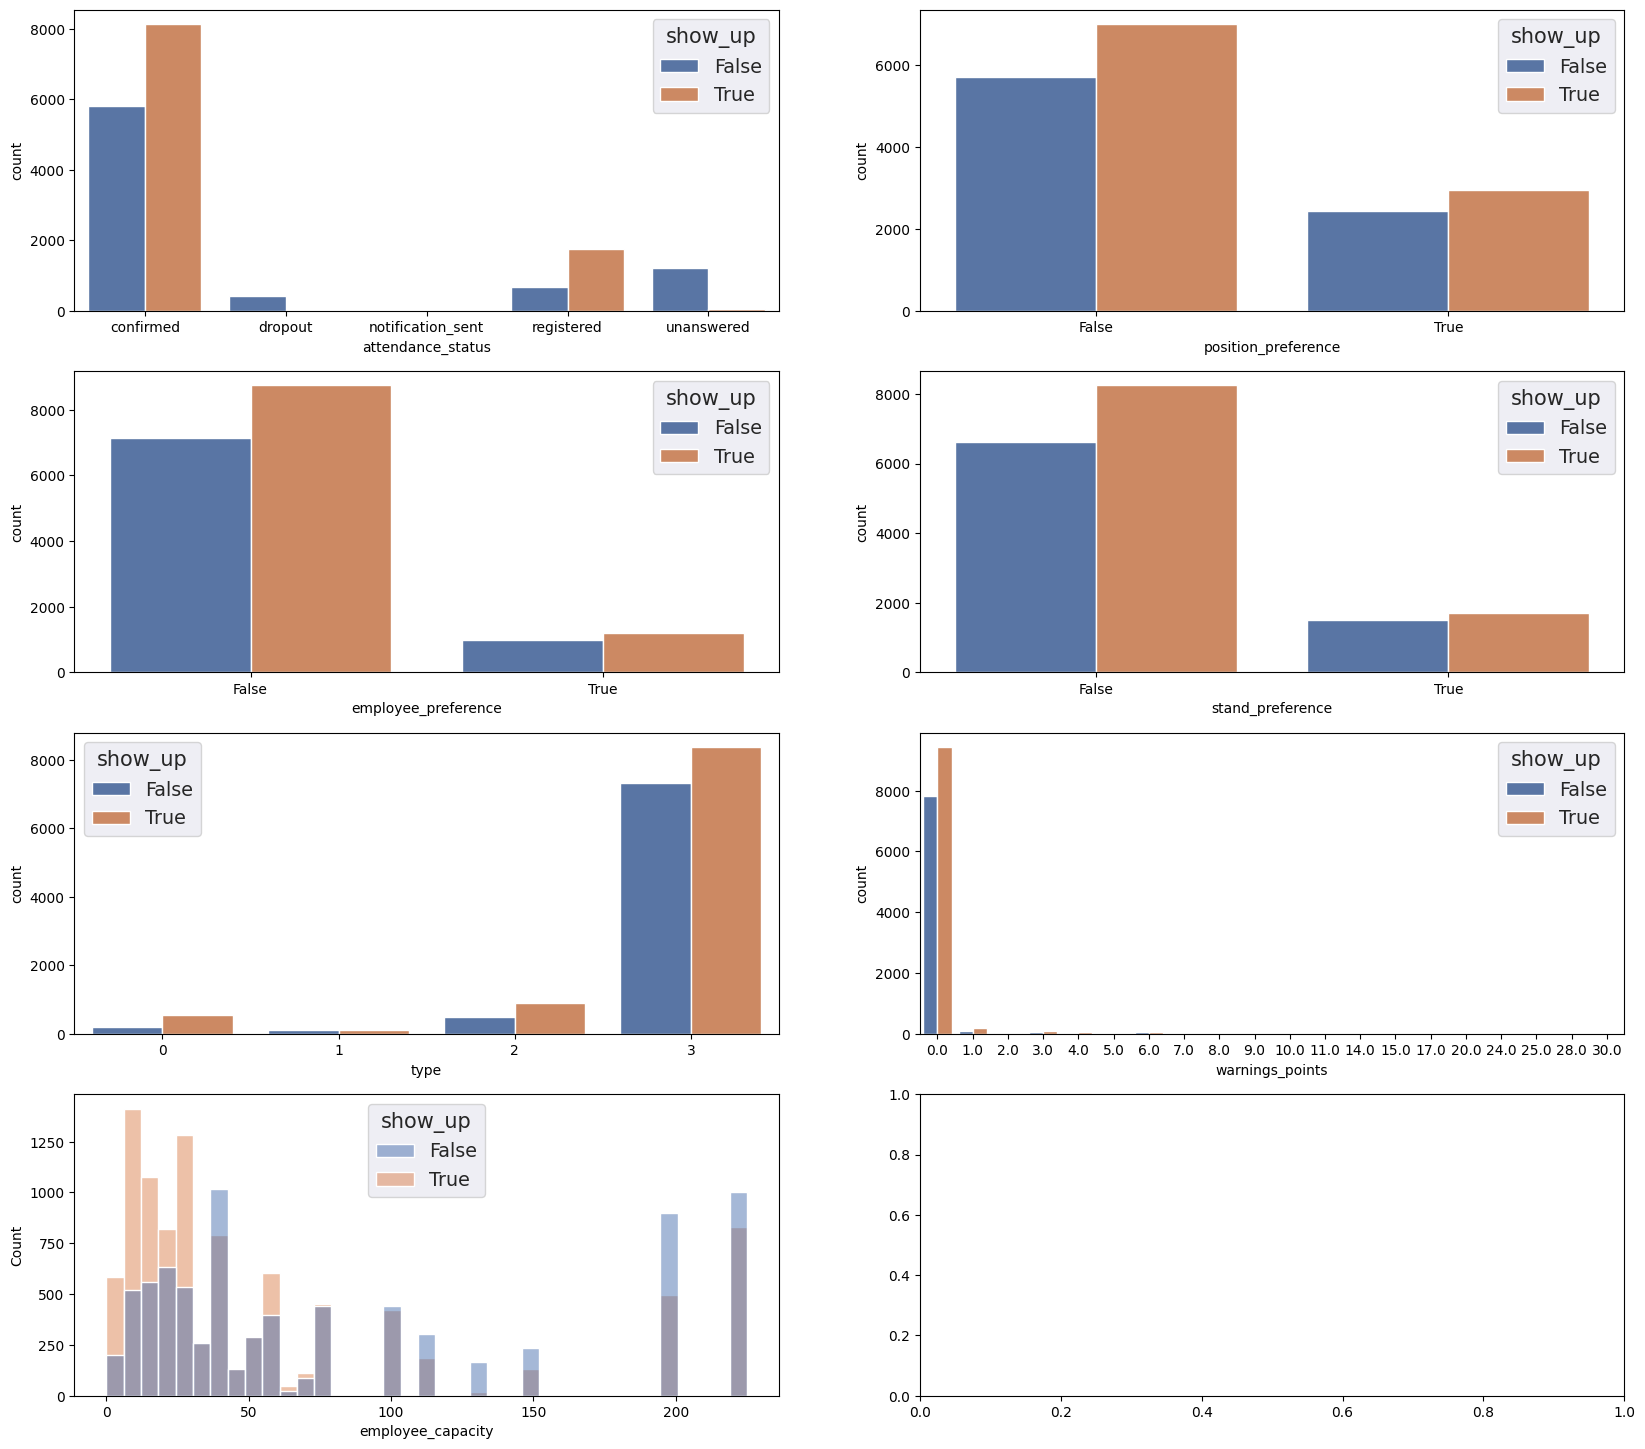

In [69]:
# Create Barcharts and scaterplots for key variables that are split by our target variable(show_up):
fig, axarr = plt.subplots(4, 2, figsize=(20, 18))
sns.set(font_scale = 1.25)
sns.countplot(x='attendance_status', hue='show_up', data=final_df, ax=axarr[0, 0])
sns.countplot(x='position_preference', hue='show_up', data=final_df, ax=axarr[0, 1])
sns.countplot(x='employee_preference', hue='show_up', data=final_df, ax=axarr[1, 0])
sns.countplot(x='stand_preference', hue='show_up', data=final_df, ax=axarr[1, 1])
sns.countplot(x='type', hue='show_up', data=final_df, ax=axarr[2, 0])
sns.countplot(x='warnings_points', hue='show_up', data=final_df, ax=axarr[2, 1])
sns.histplot(x='employee_capacity', hue='show_up', data=final_df, ax=axarr[3, 0])
plt.show()

# 6. Data Preprocessing Pipeline


In [70]:
final_df.nunique()

,0
type,4
show_up,2
attendance_status,5
position_preference,2
employee_preference,2
stand_preference,2
num_of_events_worked,71
time_since_last_event,223
time_passed_report_time,5389
warnings_points,20


In [71]:
# 1. Create a function that does all pre-processing steps for us

def PrePipe(df, drop_dummy=True):
  # 1a Reorder the columns, dropping unused
  continuous_vars = ["warnings_points", "employee_capacity", "time_since_last_event"]
  cat_cols = ["attendance_status", "position_preference", "employee_preference", "stand_preference", "type"]
  zero_one_cols = ["position_preference", "employee_preference", "stand_preference"]
  df = df[cat_cols + continuous_vars + zero_one_cols + ["show_up"]]

  # 1b Convert any Timedelta columns to numeric
  for col in continuous_vars:
      if pd.api.types.is_timedelta64_dtype(df[col]):
          df.loc[:, col] = df[col].dt.total_seconds()


  # 1c Mix-max scale the data between 0 and 1
  df.loc[:,continuous_vars] = minmax_scale(df[continuous_vars])

  # 1d One-Hot Encode Categorical Variables
  return pd.get_dummies(df[['show_up'] + continuous_vars + zero_one_cols + cat_cols], columns = cat_cols, drop_first=drop_dummy) # Understand: why we have drop_first?

In [72]:
# Testing:

#WARNING
final_df.drop(columns="time_passed_report_time", inplace=True) # we need to predit in advance
final_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18080 entries, (515, 1806) to (356, 1057)
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   type                   18080 non-null  category      
 1   show_up                18080 non-null  bool          
 2   attendance_status      18080 non-null  category      
 3   position_preference    18080 non-null  bool          
 4   employee_preference    18080 non-null  bool          
 5   stand_preference       18080 non-null  bool          
 6   num_of_events_worked   18080 non-null  int64         
 7   time_since_last_event  18080 non-null  timedelta64[s]
 8   warnings_points        18080 non-null  float64       
 9   employee_capacity      18080 non-null  float64       
dtypes: bool(4), category(2), float64(2), int64(1), timedelta64[s](1)
memory usage: 845.7 KB


In [73]:
# 2. Load data and Pre-process
df = PrePipe(final_df)
print(df.shape)
df.head()

(18080, 23)


,,show_up,warnings_points,employee_capacity,time_since_last_event,attendance_status_dropout,attendance_status_notification_sent,attendance_status_registered,attendance_status_unanswered,position_preference_True,position_preference_True,position_preference_True,position_preference_True,employee_preference_True,employee_preference_True,employee_preference_True,employee_preference_True,stand_preference_True,stand_preference_True,stand_preference_True,stand_preference_True,type_1,type_2,type_3
employee_id,event_id,,,,,,,,,,,,,,,,,,,,,,,
515,1806,True,0.000000,0.080000,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8564,1806,True,0.066667,0.080000,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9957,1564,False,0.000000,0.026667,0.000000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9931,1506,True,0.000000,0.053333,0.000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2944,1506,False,0.000000,0.053333,0.003717,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# 7. Show_Up Prediction Model


## 7.1 Classifier Performance


In [74]:
# 1. Function to output best model score, parameters and estimator
def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

# 2. Function to output accuracy score, visualize the confusion matrix, and print the classification report
def show_results(y_test, y_pred):
  # 2a. Output the accuracy of our prediction
  print(accuracy_score(y_test, y_pred))
  # 2b. Visualize the confusion matrix to make it easier to read
  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Showed Up', 'Not Showed Up'), ('Showed Up', 'Not Showed Up'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)
  # 2c. Print the classification report
  print(classification_report(y_test, y_pred))

## 7.2 Let's use Logistic Regression to predict Show Up Rate


### 7.2.1 Load and Pre-process Data


In [75]:
# 1. Start by loading and pre-processing our data
df = PrePipe(final_df, drop_dummy=True)

# 2. Separate our target and input variables.
y = df["show_up"]
X = df.drop(columns=["show_up"])

# 3. split sample into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 4. Check if data have right shape
print("Train: Response Variable: ",y_train.shape)
print("Train: Feature Variables: ",X_train.shape)
print("Test: Response Variable: ",y_test.shape)
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (12656,)
Train: Feature Variables:  (12656, 22)
Test: Response Variable:  (5424,)
Test: Feature Variables:  (5424, 22)


### 7.2.2 Train a Logistic Regression Model


0.6696165191740413
              precision    recall  f1-score   support

       False       0.69      0.49      0.57      2441
        True       0.66      0.82      0.73      2983

    accuracy                           0.67      5424
   macro avg       0.67      0.65      0.65      5424
weighted avg       0.67      0.67      0.66      5424



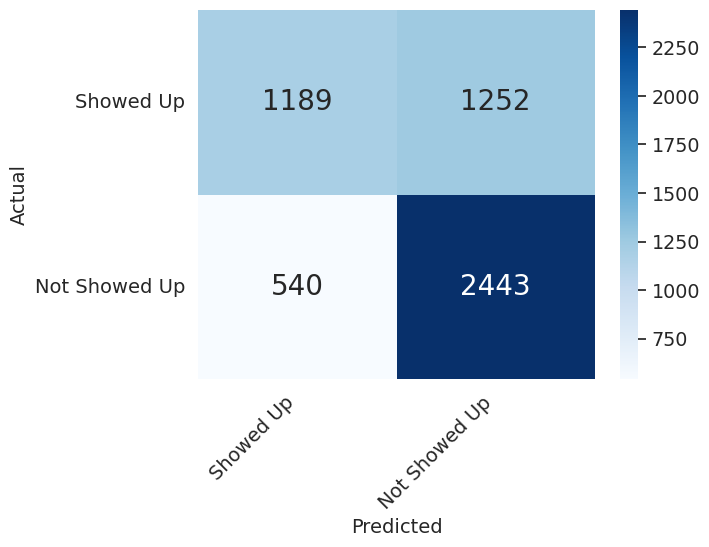

In [76]:
# 1. Instantiate the classifier: logreg
logreg = LogisticRegression(solver='lbfgs', C=1, tol=.0001, max_iter=1000)

# 2. Fit the classifier to the training data
logreg.fit(X_train, y_train)

# 3. Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# 4. Call function to evaluate model performance and show results
show_results(y_test, y_pred)

In [77]:
# 5. We can examine the intercept as follows:
print (f'Logistic Regression Intercept: {logreg.intercept_[0]}')

# 6. We can examine the coefficients as follows:
print (f'\nLogistic Regression Coefficients: {logreg.coef_[0]}')

Logistic Regression Intercept: 1.3185371696052388

Logistic Regression Coefficients: [ 0.23475814 -0.86939361 -1.12466868 -4.19085619 -0.58956303  0.2712452
 -3.61925115  0.01015892  0.01015892  0.01015892  0.01015892  0.02508992
  0.02508992  0.02508992  0.02508992 -0.04417137 -0.04417137 -0.04417137
 -0.04417137 -0.49325241  0.14216626 -0.37741308]


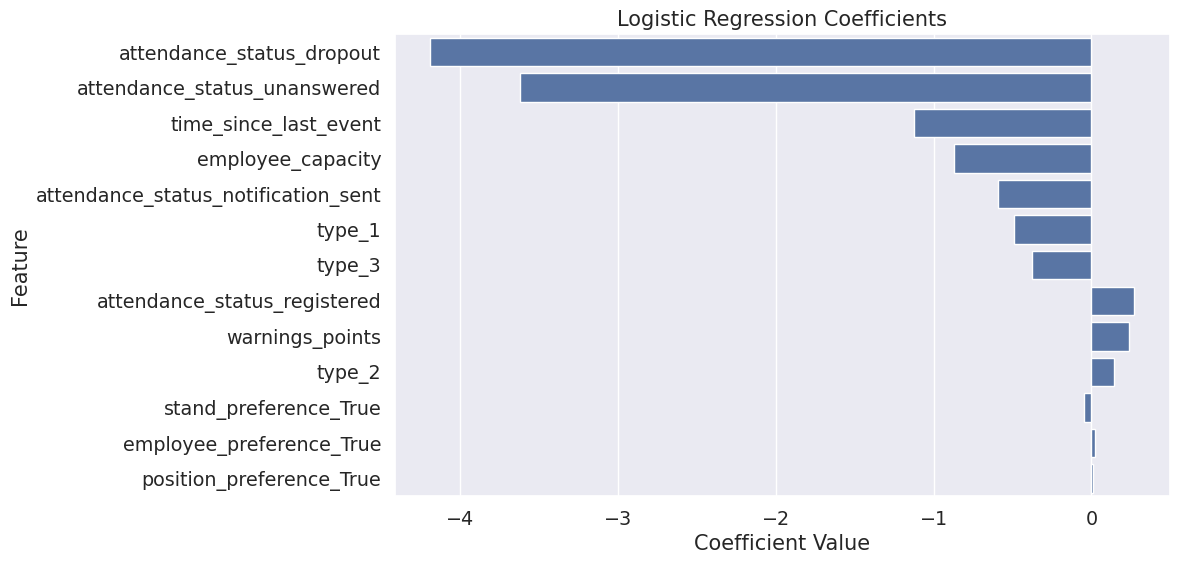

In [85]:
# prompt: Show coefficients in a nice chart format

import pandas as pd
import matplotlib.pyplot as plt
# 7. Let's show coefficients in a nice chart format
# Create a list of feature names
feature_names = X_train.columns

# Create a DataFrame of coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg.coef_[0]})

# Sort the DataFrame by coefficient values
coefficients_df = coefficients_df.sort_values('Coefficient', key=abs, ascending=False)

# Create a bar plot of coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


### 7.2.3 Improving Logistic Regression model

Let's tune our hyperparameters using a Grid-Search with Cross-Fold validation


In [78]:
# 1. Define parameter space to test
param_grid = {'C': [.1,1,10], 'tol':[.001, .0001, .00001]}

# 2. Instantiate model: Note that we can define which score (i.e., performance metric such as precision or recall) we want to tune the hyperparameters towards. WHY would we do so?
log_Grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000),param_grid, cv=5, refit=True, verbose=0, scoring = 'precision')

# 3. Fit model to data
log_Grid.fit(X_train, y_train);

# 4. Show model accuracy and best parameters (i.e., tuned)
print(best_model(log_Grid))

0.6612298428764458
{'C': 0.1, 'tol': 0.001}
LogisticRegression(C=0.1, max_iter=1000, tol=0.001)
None


0.6705383480825958
              precision    recall  f1-score   support

       False       0.69      0.49      0.57      2441
        True       0.66      0.82      0.73      2983

    accuracy                           0.67      5424
   macro avg       0.68      0.65      0.65      5424
weighted avg       0.67      0.67      0.66      5424



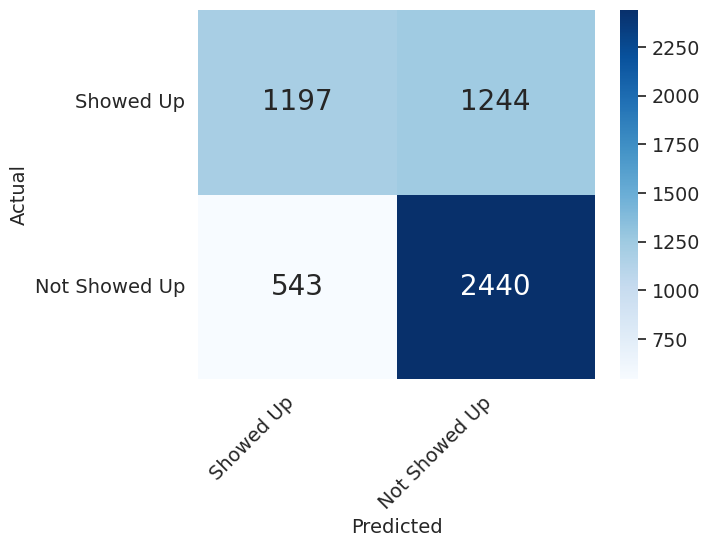

In [79]:
# 5. Model is already trained with the optimal parameters identified and set
y_pred = log_Grid.predict(X_test)

# 6. Call function to evaluate model performance and show results
show_results(y_test, y_pred)

# The code below produces the same results because we set refit=True in our grid search above

#LR=LogisticRegression(C=10, solver='lbfgs', tol=0.001)
#LR.fit(X_train, y_train);
#y_pred = LR.predict(X_test)
#show_results(y_test, y_pred)

### **Which "Square" of the Confusion Matrix do we care for most?**

---

<p style="text-align: left; font-size:120%; font-weight: normal; font-style: normal;">
$\text{Accuracy} = \frac{t_p + t_n}{t_p + t_n + f_p + f_n}$ <br><br>
$\text{Precision} = \frac{t_p}{t_p + f_p}$    <br><br>    
$\text{Recall} = \frac{t_p}{t_p + f_n}$   <br><br>    
$F_1 \text{ score} = 2 \times \frac{\textit{precision}\, \times \,\textit{recall}}{\textit{precision}\, + \,\textit{recall}}$
</p>

---

####**Precision** measures the ability of the classifier not to mislabel a negative sample as positive ####**Recall** measures the ability of the classifier to find all the positive samples.


## 7.3 Decision Tree for


In [80]:
# 1. Start by loading and pre-processing our data
df = PrePipe(final_df, drop_dummy=True)

# 2. Separate our target and input variables.
y = df.show_up
X = df.drop(columns=['show_up'])

# 3. split sample into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# 4. Check if data have right shape
print("Train: Response Variable: ",y_train.shape)
print("Train: Feature Variables: ",X_train.shape)
print("Test: Response Variable: ",y_test.shape)
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (10848,)
Train: Feature Variables:  (10848, 22)
Test: Response Variable:  (7232,)
Test: Feature Variables:  (7232, 22)


### 7.3.2 Train a Random Forest Model


0.6821073008849557
              precision    recall  f1-score   support

       False       0.72      0.48      0.58      3255
        True       0.67      0.85      0.75      3977

    accuracy                           0.68      7232
   macro avg       0.69      0.66      0.66      7232
weighted avg       0.69      0.68      0.67      7232



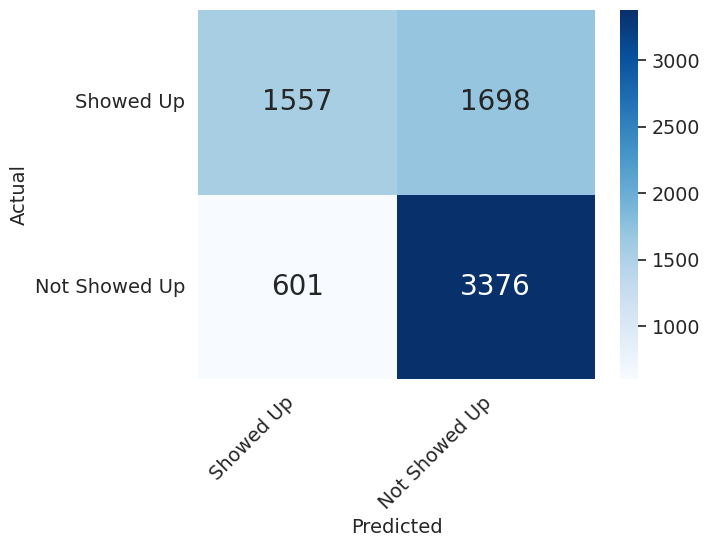

In [81]:
# 1. Instantiate a Random Forest Classifier (RandomForestClassifier was previously imported from sklearn)
forest = RandomForestClassifier(max_features=3, n_estimators=100, max_depth=5, random_state=42)

# 2. Train the model using the training sets
forest.fit(X_train, y_train)

# 3. Predict the response for test dataset
y_pred = forest.predict(X_test)

# 4. Call function to evaluate and show model performance
show_results(y_test, y_pred)

### 7.3.3 Let's tune our hyperparameters using a Grid-Search with Cross-Fold validation


In [82]:
# 1. Define grid (i.e., hyperparameter combinations to test for)
param_grid = {'n_estimators': [25, 50, 100], 'max_depth' : [5, 6, 7], 'max_features' : [3, 6, 9]}

# 2. Instantiate the model (do not include parameters from the parameter grid in the classifier that you use; here, RandomForestClassifier())
forest_Grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, refit=True, verbose=0, scoring = 'recall')

# 3. Fit the model (i.e., train it on training data)
forest_Grid.fit(X_train, y_train);

# 4. Output optimal Hyperparameter combination
print(best_model(forest_Grid))

0.833393848257774
{'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
RandomForestClassifier(max_depth=5, max_features=3, random_state=42)
None


0.6821073008849557
              precision    recall  f1-score   support

       False       0.72      0.48      0.58      3255
        True       0.67      0.85      0.75      3977

    accuracy                           0.68      7232
   macro avg       0.69      0.66      0.66      7232
weighted avg       0.69      0.68      0.67      7232



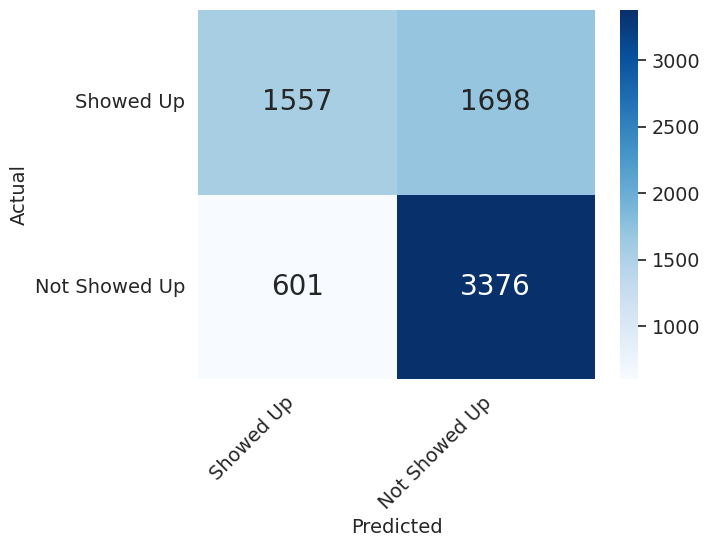

In [83]:
# 5. Model is already trained with the optimal parameters identified and set: Use it to make prediction
y_pred = forest_Grid.predict(X_test)

# 6. Call function to evaluate model performance and show results
show_results(y_test, y_pred)

In [84]:
y_pred

array([ True, False,  True, ..., False,  True,  True])

### Evaluating Overfitting


0.681047197640118
              precision    recall  f1-score   support

       False       0.72      0.48      0.57      4882
        True       0.66      0.85      0.75      5966

    accuracy                           0.68     10848
   macro avg       0.69      0.66      0.66     10848
weighted avg       0.69      0.68      0.67     10848



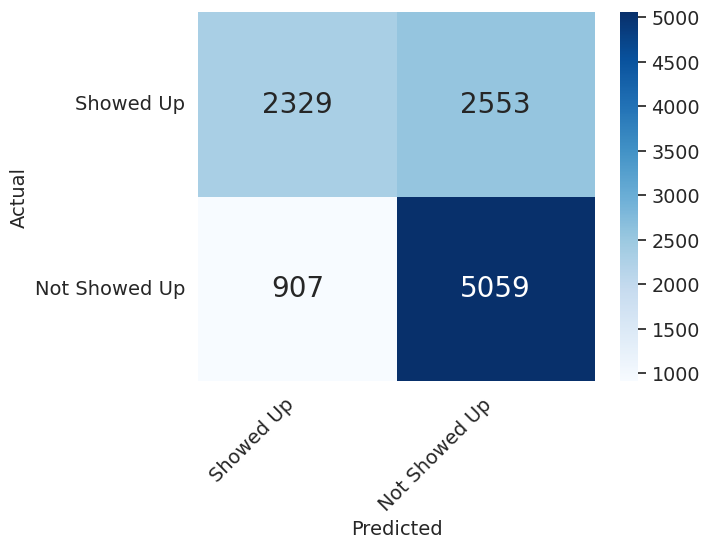

In [ ]:
train_pred = forest.predict(X_train)
show_results(y_train, train_pred)

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(forest, X_train, y_train, cv=5)
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())

Cross-Validation Scores:  [0.68387097 0.66682028 0.66313364 0.66851083 0.67819272]
Mean CV Score:  0.6721056869631358


### 7.3.4 Let's take a look at which features are most important for our prediction


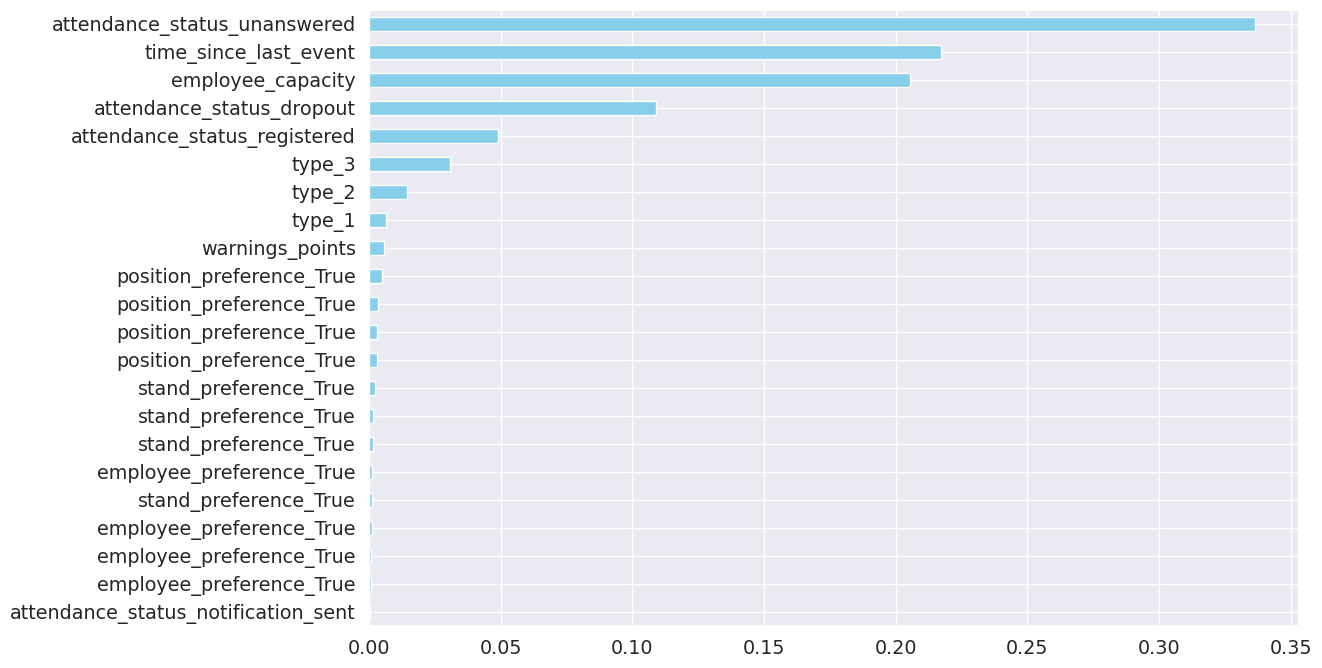

In [ ]:
# 1. Extract features and their importances
feat_importances = pd.Series(forest.feature_importances_, index=X_train.columns)

# 2. Sort importances_rf
sorted_importances_rf = feat_importances.sort_values()

# 3. Make a horizontal bar plot
plt.figure(figsize=(12,8))
sorted_importances_rf.plot(kind='barh', color='skyblue');
plt.show()

# 8. Performance Analysis


In [ ]:
# Let's get a new copy of the final_df
performance_df = final_df.copy()
performance_df.reset_index(inplace=True)
performance_df.head()

,employee_id,event_id,type,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,warnings_points,employee_capacity
0,515,1806,3,True,confirmed,False,False,False,81,54 days 00:00:00,0.0,18.0
1,8564,1806,3,True,confirmed,False,False,False,47,54 days 00:00:00,2.0,18.0
2,9957,1564,3,False,notification_sent,False,False,False,2,54 days 00:00:00,0.0,6.0
3,9931,1506,3,True,registered,False,False,False,1,54 days 00:00:00,0.0,12.0
4,2944,1506,0,False,registered,False,False,False,37,55 days 00:00:00,0.0,12.0


In [ ]:
# Let's get a list of top capacity events and see how does the model performs
performance_df.groupby("event_id").size().sort_values(ascending=False).head(10)


event_id
986     452
925     438
924     376
923     363
926     342
927     312
987     284
1017    230
941     215
933     186
dtype: int64

In [ ]:
# Applying the model
df_prepipe = PrePipe(final_df)
performance_df["Predicted_Show_Up"] = forest_Grid.predict(df_prepipe.drop(columns=["show_up"]))
performance_df.head()


,employee_id,event_id,type,show_up,attendance_status,position_preference,employee_preference,stand_preference,num_of_events_worked,time_since_last_event,warnings_points,employee_capacity,Predicted_Show_Up
0,515,1806,3,True,confirmed,False,False,False,81,54 days 00:00:00,0.0,18.0,True
1,8564,1806,3,True,confirmed,False,False,False,47,54 days 00:00:00,2.0,18.0,True
2,9957,1564,3,False,notification_sent,False,False,False,2,54 days 00:00:00,0.0,6.0,True
3,9931,1506,3,True,registered,False,False,False,1,54 days 00:00:00,0.0,12.0,True
4,2944,1506,0,False,registered,False,False,False,37,55 days 00:00:00,0.0,12.0,True


In [ ]:
# Merging "show_up" and "Predited_Show_Up"
grouped_show_up = performance_df.groupby("event_id")["show_up"].sum().reset_index(name='show_up')
grouped_predicted_show_up = performance_df.groupby("event_id")["Predicted_Show_Up"].sum().reset_index(name='Predicted_Show_Up')
grouped_jobs_count = performance_df.groupby("event_id").size().reset_index(name='jobs_count')

staffing_df = pd.merge(grouped_show_up, grouped_predicted_show_up, on="event_id", how="outer")
staffing_df = pd.merge(staffing_df, grouped_jobs_count, on="event_id", how="outer")
staffing_df = pd.merge(staffing_df, performance_df[["event_id", "employee_capacity"]].drop_duplicates(), on="event_id", how="outer")

staffing_df

,event_id,show_up,Predicted_Show_Up,jobs_count,employee_capacity
0,523,11,10,11,11.0
1,524,16,13,19,15.0
2,525,22,31,61,18.0
3,528,11,10,12,11.0
4,557,32,18,85,50.0
5,742,10,10,24,13.0
6,743,18,19,34,16.0
7,744,13,19,36,20.0
8,753,12,12,32,18.0
9,754,14,26,44,25.0


In [ ]:
# Create a "staffing_diff"
staffing_df["staffing_diff_actual"] = staffing_df["employee_capacity"] - staffing_df["show_up"]
staffing_df["staffing_diff_predicted"] = staffing_df["employee_capacity"] - staffing_df["Predicted_Show_Up"]
staffing_df["actual_vs_predicted"] = staffing_df["show_up"] - staffing_df["Predicted_Show_Up"]
staffing_df

,event_id,show_up,Predicted_Show_Up,jobs_count,employee_capacity,staffing_diff_actual,staffing_diff_predicted,actual_vs_predicted
0,523,11,10,11,11.0,0.0,1.0,1
1,524,16,13,19,15.0,-1.0,2.0,3
2,525,22,31,61,18.0,-4.0,-13.0,-9
3,528,11,10,12,11.0,0.0,1.0,1
4,557,32,18,85,50.0,18.0,32.0,14
5,742,10,10,24,13.0,3.0,3.0,0
6,743,18,19,34,16.0,-2.0,-3.0,-1
7,744,13,19,36,20.0,7.0,1.0,-6
8,753,12,12,32,18.0,6.0,6.0,0
9,754,14,26,44,25.0,11.0,-1.0,-12


In [ ]:
staffing_df.describe()

,event_id,show_up,Predicted_Show_Up,jobs_count,employee_capacity,staffing_diff_actual,staffing_diff_predicted,actual_vs_predicted
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,1405.307971,18.012681,20.740942,32.753623,23.297101,5.284420,2.556159,-2.728261
std,263.112915,22.074651,20.672713,50.979632,34.843057,19.537313,30.368106,16.304122
min,523.000000,1.000000,1.000000,1.000000,0.000000,-46.000000,-117.000000,-103.000000
25%,1209.750000,7.000000,8.000000,8.000000,7.000000,-1.000000,-5.000000,-5.000000
50%,1421.500000,11.000000,14.000000,16.000000,12.000000,0.000000,-1.000000,-2.000000
75%,1614.250000,20.000000,25.250000,36.000000,25.000000,4.000000,1.000000,0.000000
max,1864.000000,194.000000,157.000000,452.000000,225.000000,198.000000,189.000000,124.000000


In [ ]:
staffing_df[staffing_df["event_id"] == 1679]

,event_id,show_up,Predicted_Show_Up,jobs_count,employee_capacity,staffing_diff_actual,staffing_diff_predicted,actual_vs_predicted
465,1679,31,41,43,25.0,-6.0,-16.0,-10


## Code Graveyard


Testing


In [ ]:
events["report_time"].describe()

count                                   1137
mean     2023-12-30 04:49:41.530343168+00:00
min                2022-09-02 12:30:00+00:00
25%                2023-09-23 16:30:00+00:00
50%                2024-01-21 17:30:00+00:00
75%                2024-03-26 19:00:00+00:00
max                2024-11-16 16:00:00+00:00
Name: report_time, dtype: object